In [1]:
%matplotlib inline
import os, shutil
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio
from tqdm import tqdm
import pandas as pd

In [2]:
mode = 'notebook' #notebook, commit, colab

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

if mode == 'colab':
    import cufflinks as cf
    cf.go_offline()
    init_notebook_mode(connected=False)

    def configure_plotly_browser_state():
        import IPython
        display(IPython.core.display.HTML('''
          <script src="/static/components/requirejs/require.js"></script>
          <script>
            requirejs.config({
              paths: {
                base: '/static/base',
                plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
              },
            });
          </script>
          '''))

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

if mode == 'commit':
    pio.renderers.default = "png"


# Dataset Analysis

In [3]:
def load_data(filepath):
    sample_matlab_data = scio.loadmat(filepath)  # Structured Matlab Array containing all information
    return sample_matlab_data

basedir = 'DataFiles'

In [4]:
patient_data = []
for file in os.listdir(basedir):
    filepath = os.path.join(basedir, file)
    patient_data.append(load_data(filepath))
    
print(len(patient_data))

8


In [5]:
patient_data[0]

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Tue Nov 25 12:46:00 2014',
 '__version__': '1.0',
 '__globals__': [],
 'data': array([[(array([[array(['Fz'], dtype='<U2'), array(['Cz'], dtype='<U2'),
                 array(['Pz'], dtype='<U2'), array(['Oz'], dtype='<U2'),
                 array(['P3'], dtype='<U2'), array(['P4'], dtype='<U2'),
                 array(['PO7'], dtype='<U3'), array(['PO8'], dtype='<U3')]],
               dtype=object), array([[ -1.21978372,  -0.32769319,  -1.21995831, ...,  -2.65680554,
                   7.37202505,  -0.27890203],
                [ -1.42616224,  -4.18996393,  -5.65458822, ...,  -9.45534598,
                  -3.67053188,  -5.48506363],
                [ -1.31524453,  -6.87075831,  -8.55992067, ..., -14.26798757,
                 -11.63200572,  -8.92900433],
                ...,
                [ -3.96511643,   5.70748743,   1.11047492, ...,  -5.27998942,
                   9.13724881,  -0.85580654],
                [ -0

In [6]:
def get_channel_name(patient, index):
    return patient['data'][0][0]['channels'][0][index]
print(get_channel_name(patient_data[0], 1))

['Cz']


In [7]:
print(patient_data[0]['data'][0][0]['X'].shape)
print(patient_data[0]['data'][0][0]['y'].shape)
print(patient_data[0]['data'][0][0]['y_stim'].shape)

(347704, 8)
(347704, 1)
(347704, 1)


In [8]:
np.concatenate([patient_data[0]['data'][0][0]['X'][0:2], patient_data[0]['data'][0][0]['X'][5:7]], axis=0).shape

(4, 8)

### Calculate Trial data for each patient

In [9]:
# Functions for EEG data extraction and manipulation

sample_frequency = 256 #Hz
bandpass_filter = (0, 30) # Hz
stimulus_duration = 125 #ms
interstimulus_interval = 125 #ms
total_stimulus = 12 # 6 rows and 6 columns
number_of_times_each_stimulus_appeared_per_trial = 10
total_stimulus_appeared_per_trial = total_stimulus * number_of_times_each_stimulus_appeared_per_trial

trial_duration = (stimulus_duration * total_stimulus_appeared_per_trial) + \
(interstimulus_interval * (total_stimulus_appeared_per_trial- 1))

samples_per_trial = (sample_frequency * trial_duration)//1000

print(f"Each trial duration: {trial_duration} ms or {samples_per_trial} samples")

Each trial duration: 29875 ms or 7648 samples


In [10]:
def get_trials(sample, remove_calibration_data=True):
    data = sample['data'][0][0]
    signal = data['X']
    stimulus = data['y_stim']
    target = data['y']
    
    x, y_stimulus, y_target = [], [], []
#     trial_start = 0
    for i in range(data['trial'].shape[1]):
        trial_start = data['trial'][0, i]
        trial_end = trial_start+samples_per_trial
            
            
        # Fetch signal
        x.append(signal[trial_start:trial_end])
        # Fetch stimulus
        y_stimulus.append(stimulus[trial_start:trial_end, 0])
        # Fetch target
        y_target.append(target[trial_start:trial_end, 0])

    x, y_stimulus, y_target = np.array(x), np.array(y_stimulus), np.array(y_target)
    if remove_calibration_data:
        x, y_stimulus, y_target = x[3:], y_stimulus[3:], y_target[3:]
    return x, y_stimulus, y_target

x, y_stim, y_target = get_trials(patient_data[0])
print(x.shape, y_stim.shape, y_target.shape)
print(np.unique(y_stim))
print(np.unique(y_target))

(32, 7648, 8) (32, 7648) (32, 7648)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[0 1 2]


### Get data for each patient

In [11]:

number_of_trials_per_run = 5 # each run is a word and each trial is a character of the word
number_of_runs = 7 # total number of words

total_characters_with_calibration = number_of_trials_per_run * number_of_runs
total_characters_without_calibration = number_of_trials_per_run * number_of_runs - 3

def get_dataset(dataset):
    """
    Returns: Numpy array -> input shape: (patient_id, run, trial, sample, channels), 
             stimulus -> (patient_id, run, trial, sample)
             target -> (patient_id, run, trial, sample)
    """
    x, y_stim, y_target = [], [], []
    for i in range(len(dataset)):
        patient = dataset[i]
        x_trial, y_stim_trial, y_target_trial = get_trials(patient, remove_calibration_data=False)
        
        # Reshape array to group trials by run
        x_trial = x_trial.reshape(-1, number_of_trials_per_run, x_trial.shape[1], x_trial.shape[2])
        y_stim_trial  = y_stim_trial.reshape(-1, number_of_trials_per_run, y_stim_trial.shape[1])
        y_target_trial = y_target_trial.reshape(-1, number_of_trials_per_run, y_target_trial.shape[1])
        
        # Add to array
        x.append(x_trial)
        y_stim.append(y_stim_trial)
        y_target.append(y_target_trial)
        
    return np.array(x), np.array(y_stim), np.array(y_target)
        
        
x, y_stim, y_target = get_dataset(patient_data)

print(x.shape, y_stim.shape, y_target.shape)
print(np.unique(y_stim))
print(np.unique(y_target))

(8, 7, 5, 7648, 8) (8, 7, 5, 7648) (8, 7, 5, 7648)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[0 1 2]


### Mapping for row/column value to character

In [12]:
words =np.array([chr(i) for i in range(ord('A'), ord('Z')+1)] + [str(i) for i in range(1, 10)] + ['-'])
word_matrix = np.reshape(words, (6, 6))
word_matrix_row = np.arange(7, 13)
word_matrix_column = np.arange(1, 7)
print(word_matrix)
word_to_tup = {}
tup_to_word = {}
for i in range(word_matrix.shape[0]):
    for j in range(word_matrix.shape[1]):
        tup = (word_matrix_row[i], word_matrix_column[j])
        word_to_tup[word_matrix[i, j]] = tup
        tup_to_word[str(tup[0]) + "," + str(tup[1])] = word_matrix[i, j]
        
print("\nCharacter to indices")
print(word_to_tup)
print("\n Indices to Characters")
print(tup_to_word)

[['A' 'B' 'C' 'D' 'E' 'F']
 ['G' 'H' 'I' 'J' 'K' 'L']
 ['M' 'N' 'O' 'P' 'Q' 'R']
 ['S' 'T' 'U' 'V' 'W' 'X']
 ['Y' 'Z' '1' '2' '3' '4']
 ['5' '6' '7' '8' '9' '-']]

Character to indices
{'A': (7, 1), 'B': (7, 2), 'C': (7, 3), 'D': (7, 4), 'E': (7, 5), 'F': (7, 6), 'G': (8, 1), 'H': (8, 2), 'I': (8, 3), 'J': (8, 4), 'K': (8, 5), 'L': (8, 6), 'M': (9, 1), 'N': (9, 2), 'O': (9, 3), 'P': (9, 4), 'Q': (9, 5), 'R': (9, 6), 'S': (10, 1), 'T': (10, 2), 'U': (10, 3), 'V': (10, 4), 'W': (10, 5), 'X': (10, 6), 'Y': (11, 1), 'Z': (11, 2), '1': (11, 3), '2': (11, 4), '3': (11, 5), '4': (11, 6), '5': (12, 1), '6': (12, 2), '7': (12, 3), '8': (12, 4), '9': (12, 5), '-': (12, 6)}

 Indices to Characters
{'7,1': 'A', '7,2': 'B', '7,3': 'C', '7,4': 'D', '7,5': 'E', '7,6': 'F', '8,1': 'G', '8,2': 'H', '8,3': 'I', '8,4': 'J', '8,5': 'K', '8,6': 'L', '9,1': 'M', '9,2': 'N', '9,3': 'O', '9,4': 'P', '9,5': 'Q', '9,6': 'R', '10,1': 'S', '10,2': 'T', '10,3': 'U', '10,4': 'V', '10,5': 'W', '10,6': 'X', '11,1': '

In [13]:
target_class = 2
non_target_class = 1
def convert_stimulus_to_word(y_stim, y_target):
    """
    Input shape: (Patients, run, trial, samples)
    Output shape: (Patients, run, trial, character)
    """
    y_stim = y_stim.reshape(-1)
    y_target = y_target.reshape(-1)
    target_stimulus = y_stim[y_target == target_class ]
    vals = []
    for i in range(len(target_stimulus)):
        if len(vals) == 0 or  vals[-1] != target_stimulus[i]:
            vals.append(target_stimulus[i])

    character_indices = []
    characters = []
    for i in range(0, len(vals)-1, 2):
        c = vals[i]
        r = vals[i+1]
        character_indices.append((r, c))
        characters.append(tup_to_word[str(r) + "," + str(c)])
    
    non_repeating_chars = []
    for c in characters:
        if len(non_repeating_chars) == 0 or non_repeating_chars[-1] != c:
            non_repeating_chars.append(c)
    
    words = []
    for i in range(0, len(non_repeating_chars), 5):
        words.append(''.join(non_repeating_chars[i:i+5]))
    return words

for i in range(x.shape[0]):
    print(f"Words displayed to patient: {i+1}")
    print(convert_stimulus_to_word(y_stim[0], y_target[0]))

    

Words displayed to patient: 1
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']
Words displayed to patient: 2
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']
Words displayed to patient: 3
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']
Words displayed to patient: 4
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']
Words displayed to patient: 5
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']
Words displayed to patient: 6
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']
Words displayed to patient: 7
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']
Words displayed to patient: 8
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']


In [14]:
x.shape[-1]//2

4

# Signal Amplitude Analysis - Channel Specific

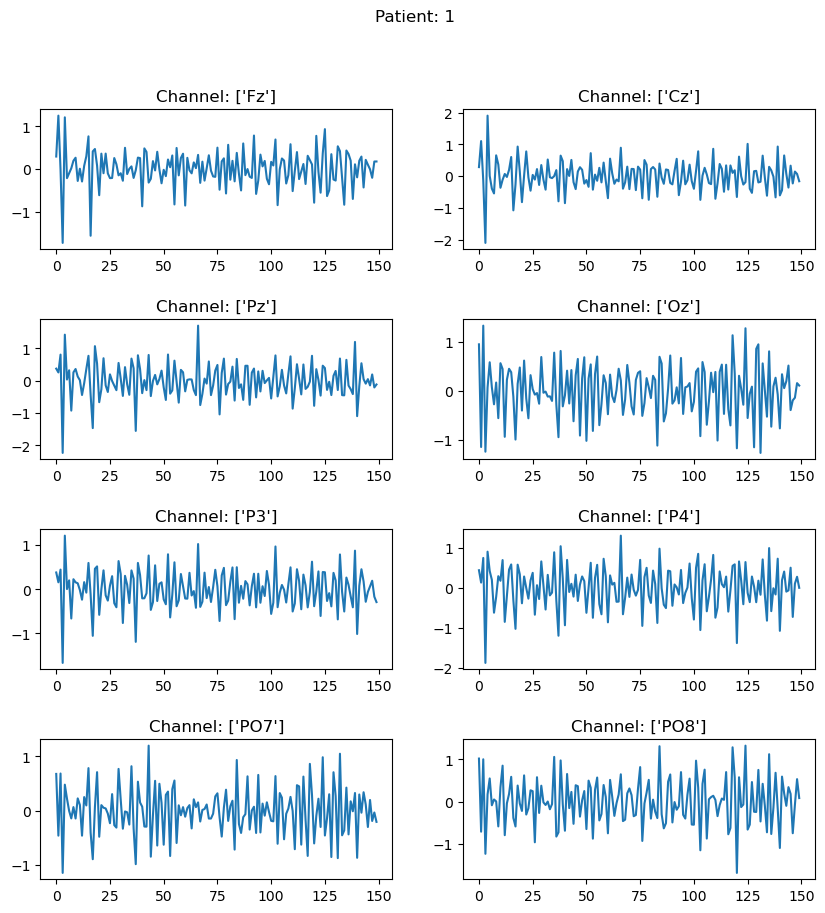

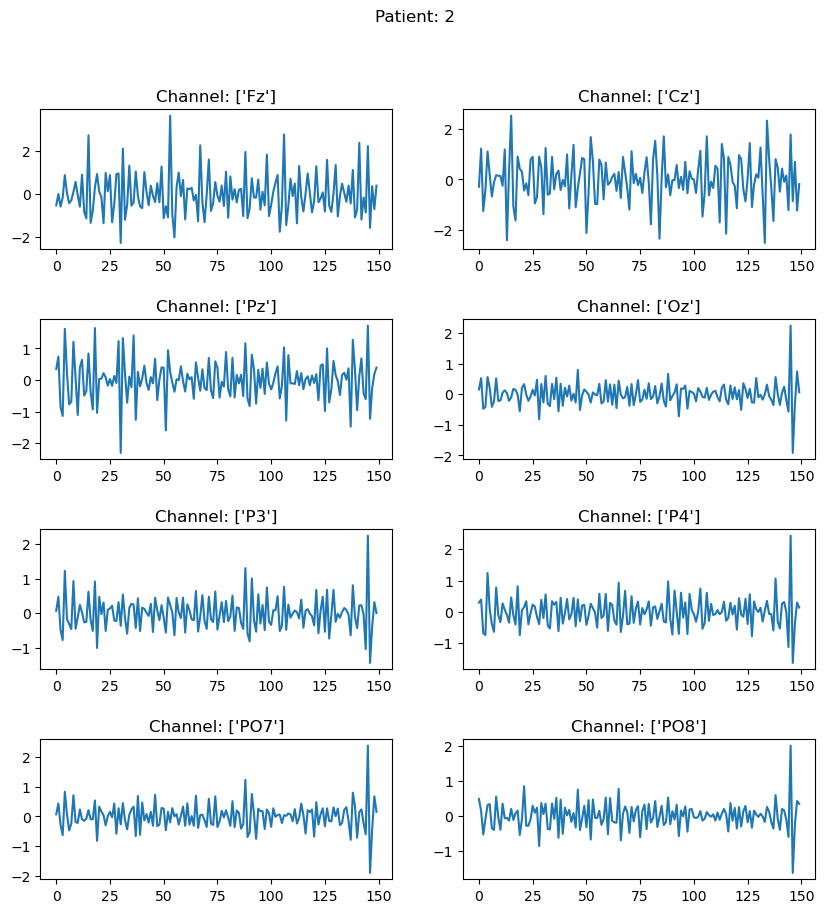

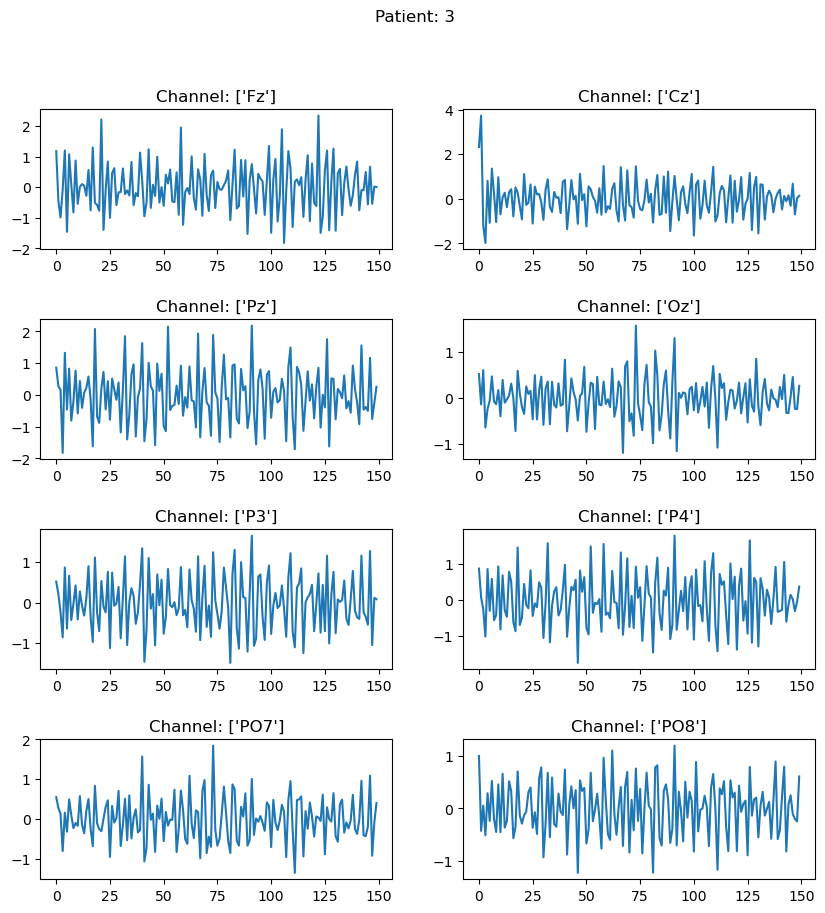

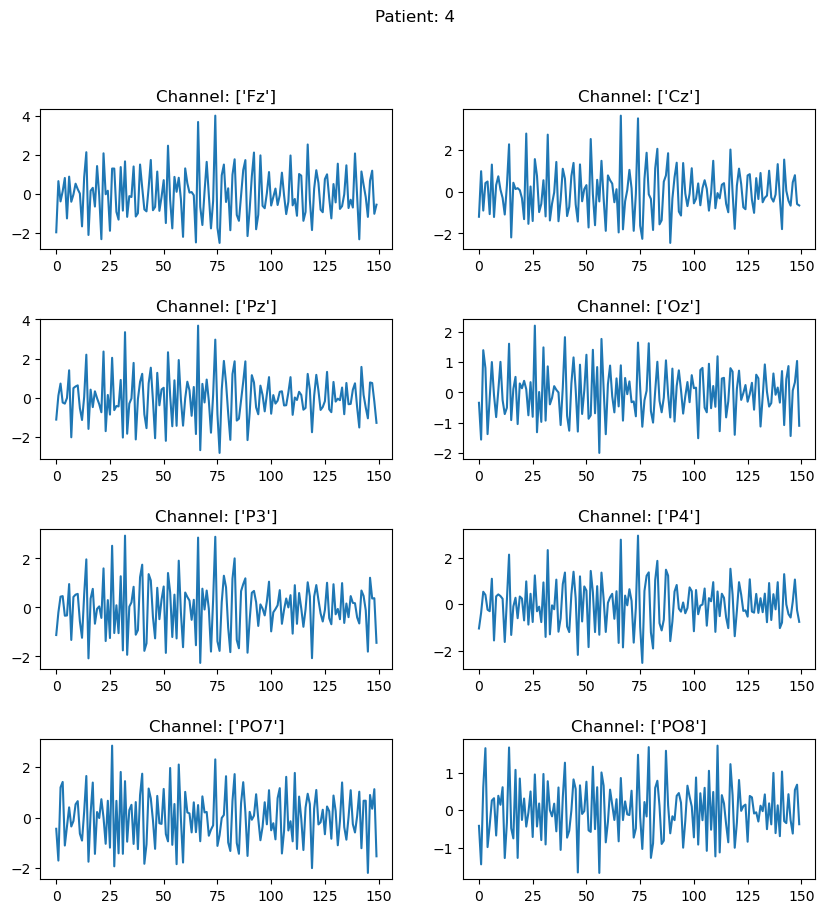

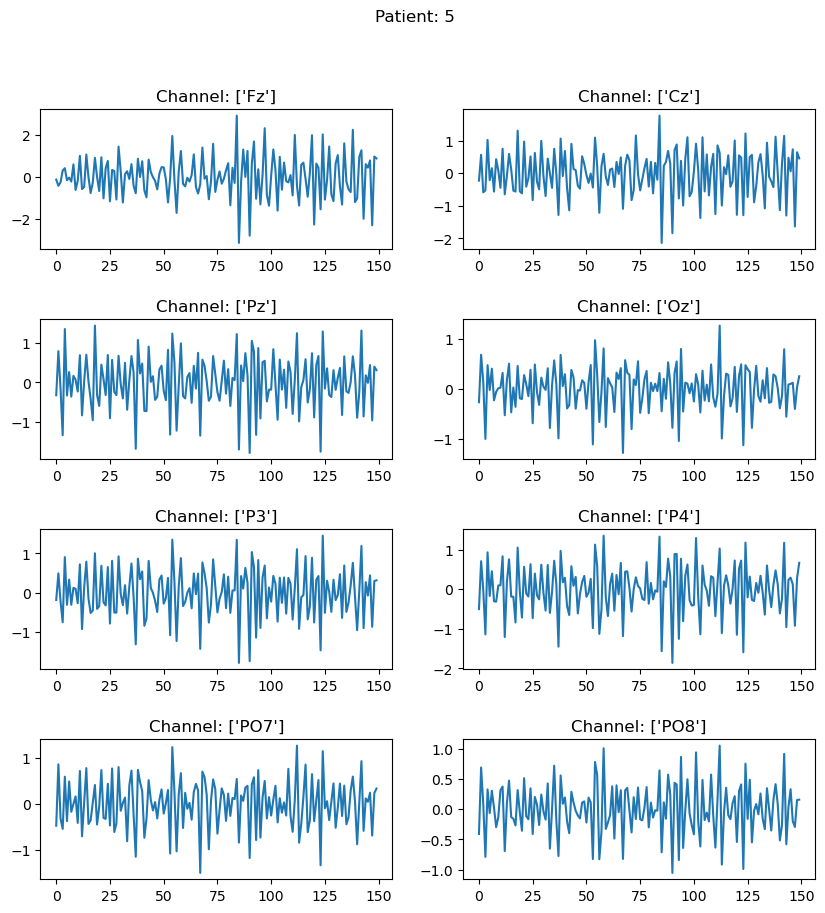

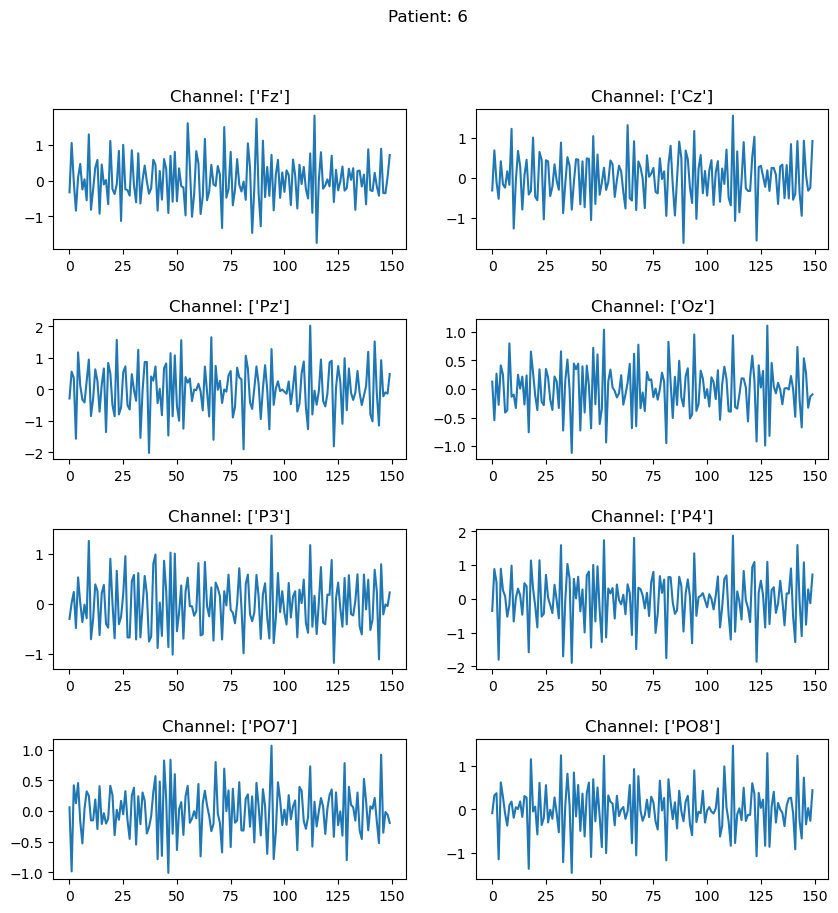

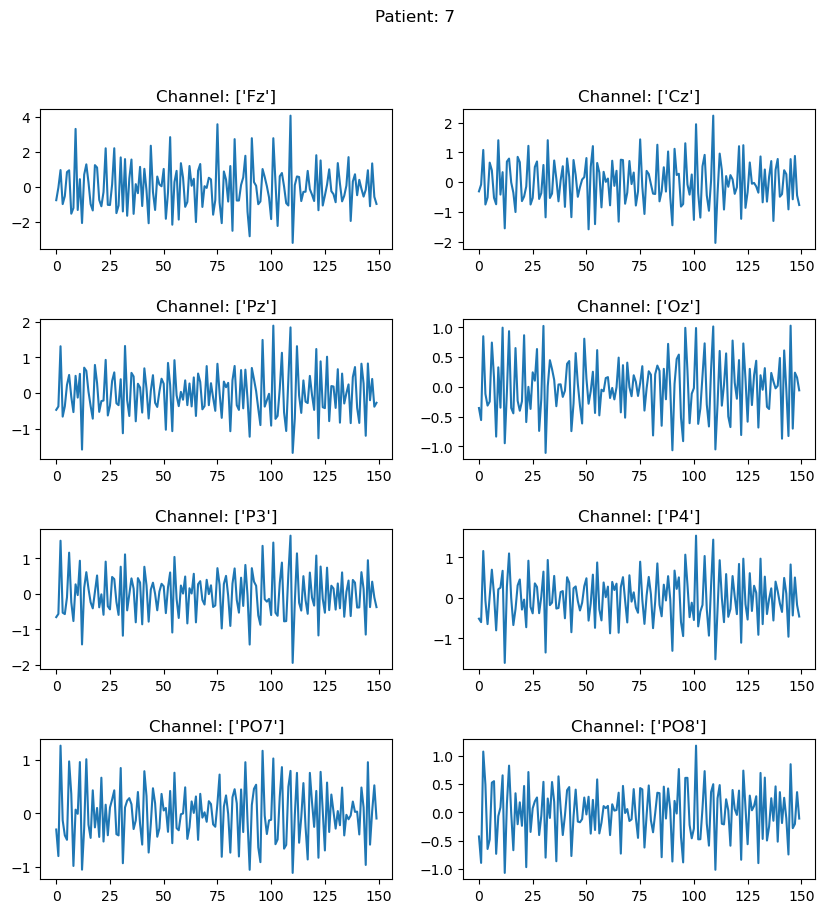

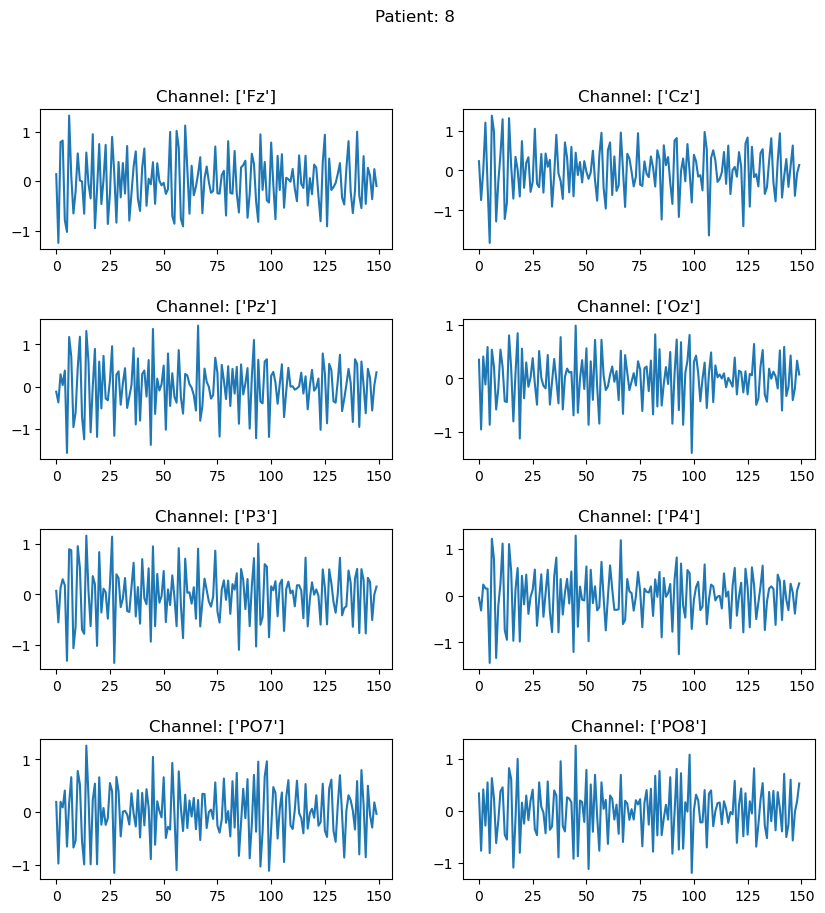

In [15]:
# Visualize channel output
mean_duration = 200 # ms Need to keep it in fraction to get an integer number of samples
mean_samples = int(sample_frequency * mean_duration/1000)
for i in range(x.shape[0]):
    cols = 2
    rows = x.shape[-1]//cols
    if int(rows) != rows:
        rows = int(rows) + 1
    else:
        rows = int(rows)
        
        
    fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
    plt.suptitle(f"Patient: {i+1}")
    current = 0
    mean = x[i].mean(axis=(0, 1))
    for j in range(rows):
        for k in range(cols):
            ax[j, k].set_title(f"Channel: {get_channel_name(patient_data[i], current)}")
            m = [np.mean(mean[z:z+mean_samples, current]) for z in range(0, mean.shape[0], mean_samples)]
            ax[j, k].plot(m)
            current += 1
    plt.subplots_adjust(hspace=0.5)
    plt.show()

## View Average waveform of each channel

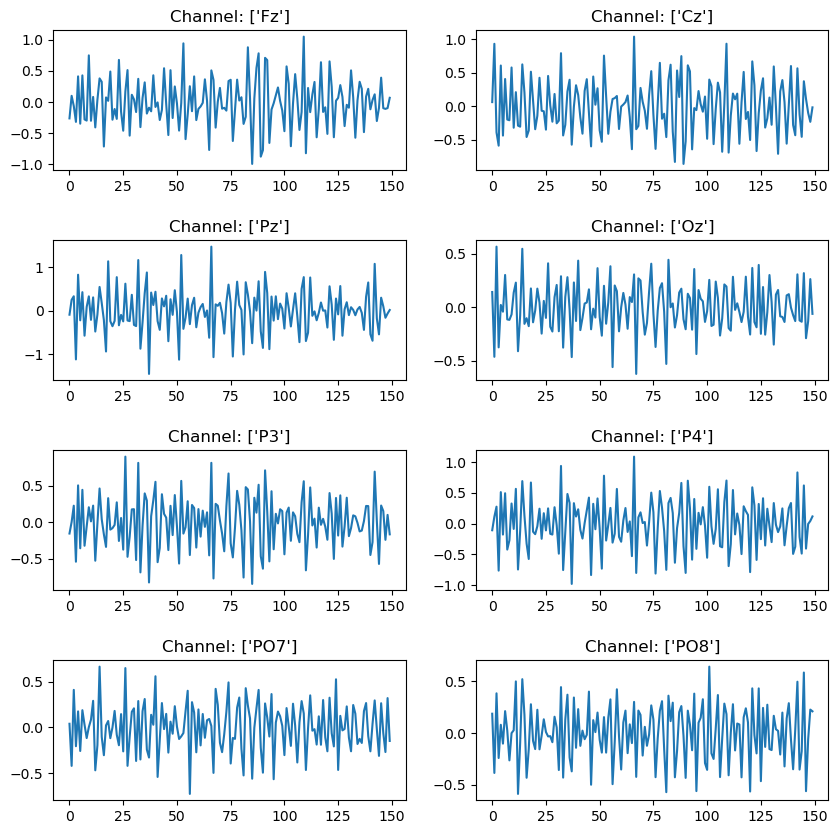

In [16]:
# Visualize channel output
mean_duration = 200 # ms Need to keep it in fraction to get an integer number of samples
mean_samples = int(sample_frequency * mean_duration/1000)
cols = 2
rows = x.shape[-1]//cols
if int(rows) != rows:
    rows = int(rows) + 1
else:
    rows = int(rows)


fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
current = 0
mean = x.mean(axis=(0, 1, 2))
for j in range(rows):
    for k in range(cols):
        ax[j, k].set_title(f"Channel: {get_channel_name(patient_data[0], current)}")
        m = [np.mean(mean[z:z+mean_samples, current]) for z in range(0, mean.shape[0], mean_samples)]
        ax[j, k].plot(m)
        current += 1
plt.subplots_adjust(hspace=0.5)
plt.show()

## Histogram distribution of each channel

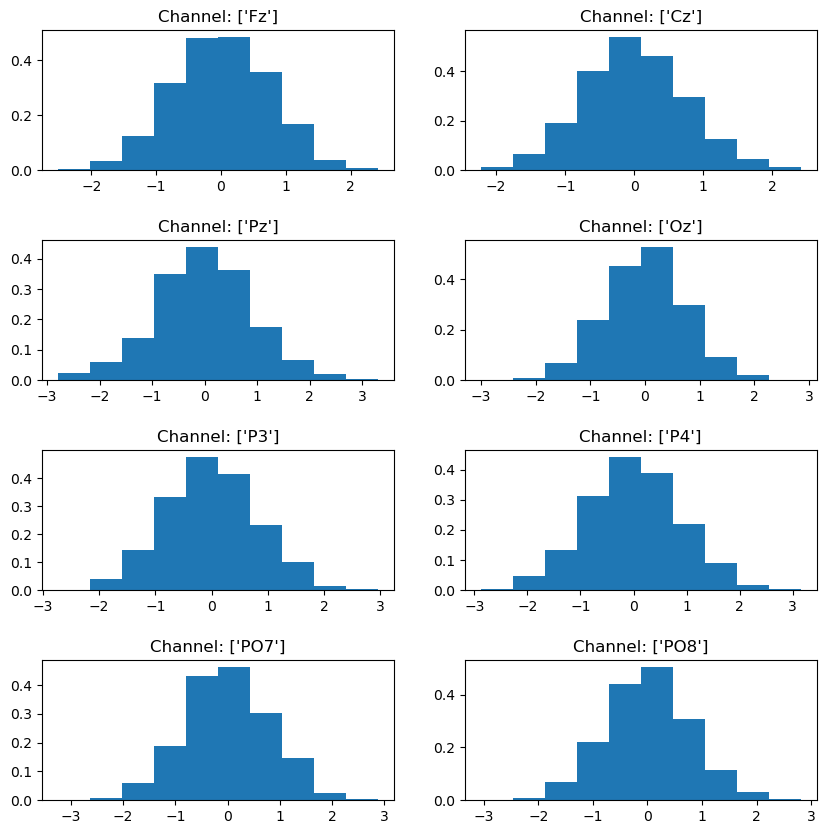

In [17]:
# Visualize channel output
cols = 2
rows = x.shape[-1]//cols
if int(rows) != rows:
    rows = int(rows) + 1
else:
    rows = int(rows)


fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
current = 0
mean = x.mean(axis=(0, 1, 2))
for j in range(rows):
    for k in range(cols):
        ax[j, k].set_title(f"Channel: {get_channel_name(patient_data[0], current)}")
        ax[j, k].hist(mean[:, current], density=True)
        current += 1
plt.subplots_adjust(hspace=0.5)
plt.show()

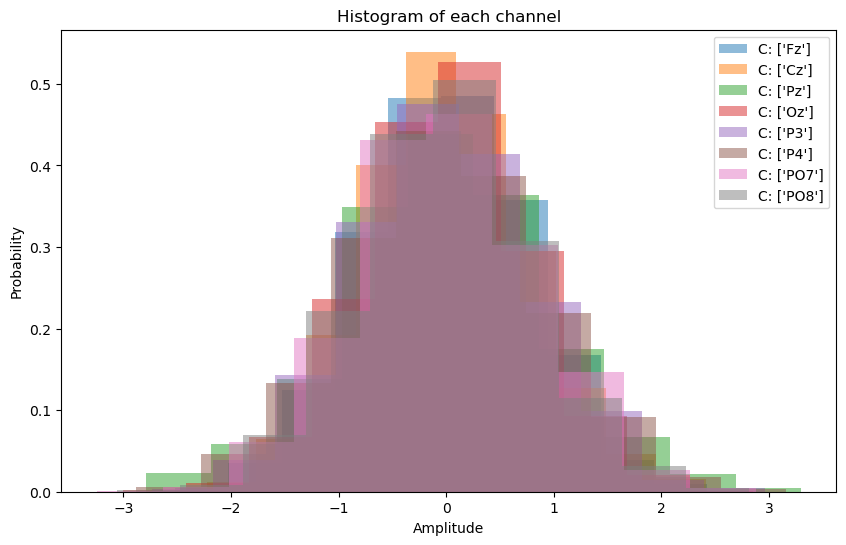

In [21]:
mean = x.mean(axis=(0, 1, 2))
plt.figure(figsize=(10, 6))
plt.title("Histogram of each channel")
for i in range(mean.shape[1]):
    plt.hist(
        mean[:, i], 
        density=True,
        alpha=0.5,
        label=f'C: {get_channel_name(patient_data[0], i)}'
    )


plt.xlabel("Amplitude")
plt.ylabel("Probability")
plt.legend()
plt.show()

The distribution of each channel is almost identical and follows a normal distribution

## Distribution of Target and Non-Target Signals

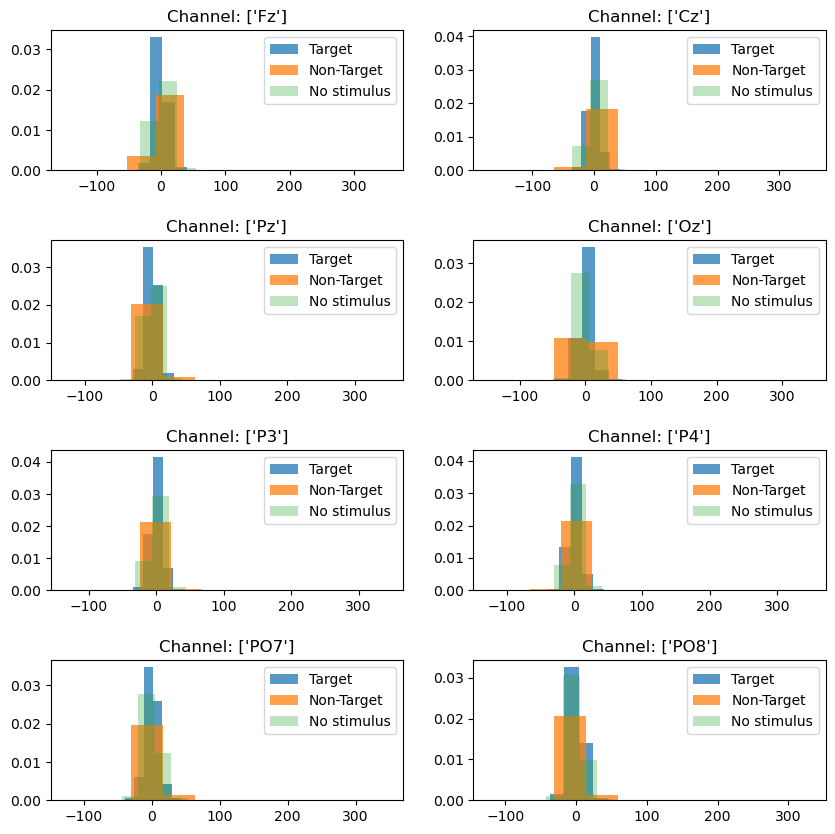

In [91]:
# Visualize channel output
cols = 2
rows = x.shape[-1]//cols
if int(rows) != rows:
    rows = int(rows) + 1
else:
    rows = int(rows)


current = 0

fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
for j in range(rows):
    for k in range(cols):
        x_channel = x[:, :, :, :, current].reshape(-1)
        
        ax[j, k].set_title(f"Channel: {get_channel_name(patient_data[0], current)}")
        ax[j, k].hist(x_channel[y_target.reshape(-1) == target_class], density=True, label='Target', alpha=0.75)
        ax[j, k].hist(x_channel[y_target.reshape(-1) == non_target_class], density=True, label='Non-Target', alpha=0.75)      
        ax[j, k].hist(x_channel[y_target.reshape(-1) == 0], density=True, label='No stimulus', alpha=0.3)      
        ax[j, k].legend()
        
        current += 1

plt.subplots_adjust(hspace=0.5)
plt.show()

We can see from the above plot that - for each channel the target signals have a high probability near zero whereas, the non-target signals are more diffused. Moreover, the amplitude of signal when no stimulus is provided follows a pattern similar to target stimulus.

In [29]:
# Calculate mean and variance of the target and non-target signals for each channel

for i in range(x.shape[-1]):
    x_channel = x[:, :, :, :, i].reshape(-1)
    target_signal = x_channel[y_target.reshape(-1) == target_class]
    nontarget_signal = x_channel[y_target.reshape(-1) == non_target_class]
    print(f"\nChannel: {get_channel_name(patient_data[0], i)}")
    print(f"Target => Mean: {np.mean(target_signal):.5f}, Variance: {np.var(target_signal):.5f}")
    print(f"Non-Target => Mean: {np.mean(nontarget_signal):.5f}, Variance: {np.var(nontarget_signal):.5f}")


Channel: ['Fz']
Target => Mean: -0.84365, Variance: 89.91908
Non-Target => Mean: -0.09898, Variance: 101.33504

Channel: ['Cz']
Target => Mean: -0.64469, Variance: 78.45835
Non-Target => Mean: -0.07870, Variance: 86.46484

Channel: ['Pz']
Target => Mean: -0.19930, Variance: 76.48355
Non-Target => Mean: 0.09531, Variance: 81.44572

Channel: ['Oz']
Target => Mean: 0.19472, Variance: 100.92308
Non-Target => Mean: 0.10605, Variance: 105.96212

Channel: ['P3']
Target => Mean: -0.09613, Variance: 79.13190
Non-Target => Mean: 0.04128, Variance: 84.34823

Channel: ['P4']
Target => Mean: -0.12381, Variance: 72.75169
Non-Target => Mean: 0.07146, Variance: 77.86436

Channel: ['PO7']
Target => Mean: 0.28197, Variance: 109.11507
Non-Target => Mean: -0.04467, Variance: 113.78973

Channel: ['PO8']
Target => Mean: 0.26678, Variance: 81.01573
Non-Target => Mean: -0.06767, Variance: 85.48183


We can see that indeed the variance of all target signal is less than their corresponding non-target signal suggesting that the non-target signals have a more scattered amplitude. When observing the mean we can see that for some channels the mean of target signals are less than their corresponding non-target signals and for others it is the opposite. So, the mean amplitude does not provide us much meaningful information.


## Distribution of Target and Non-target signal for each patient

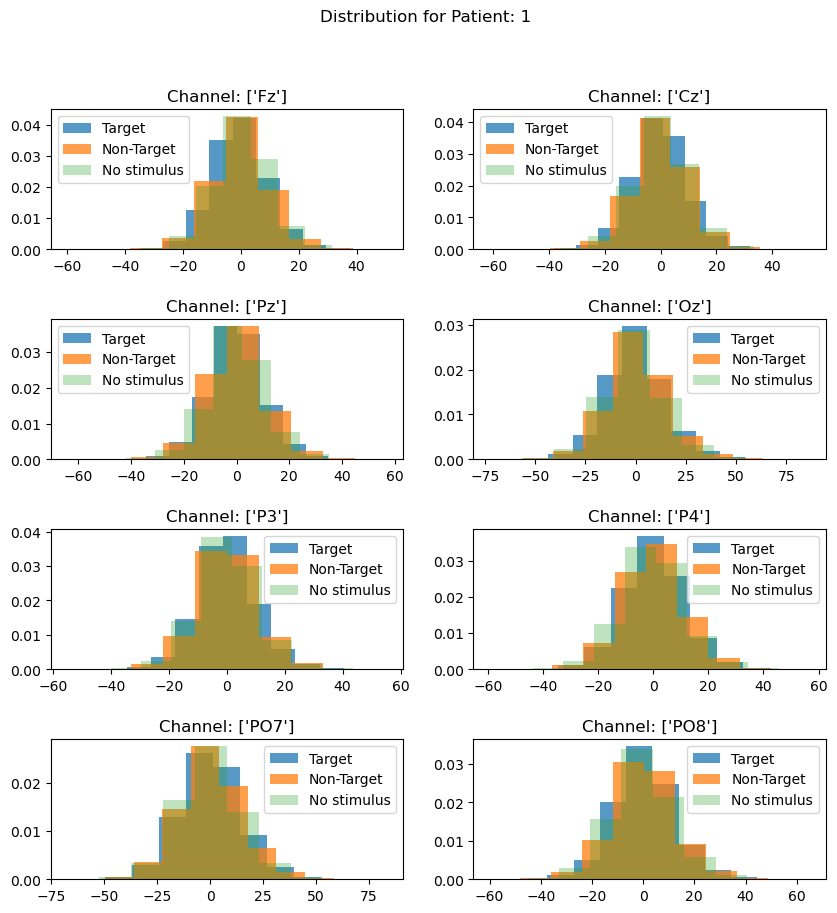

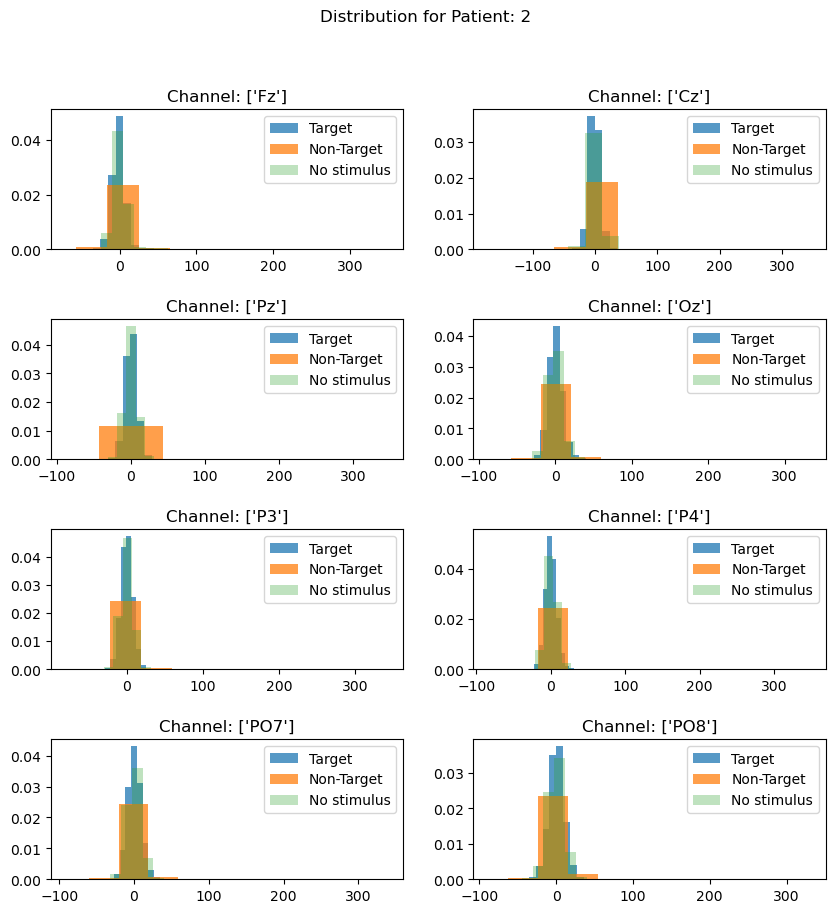

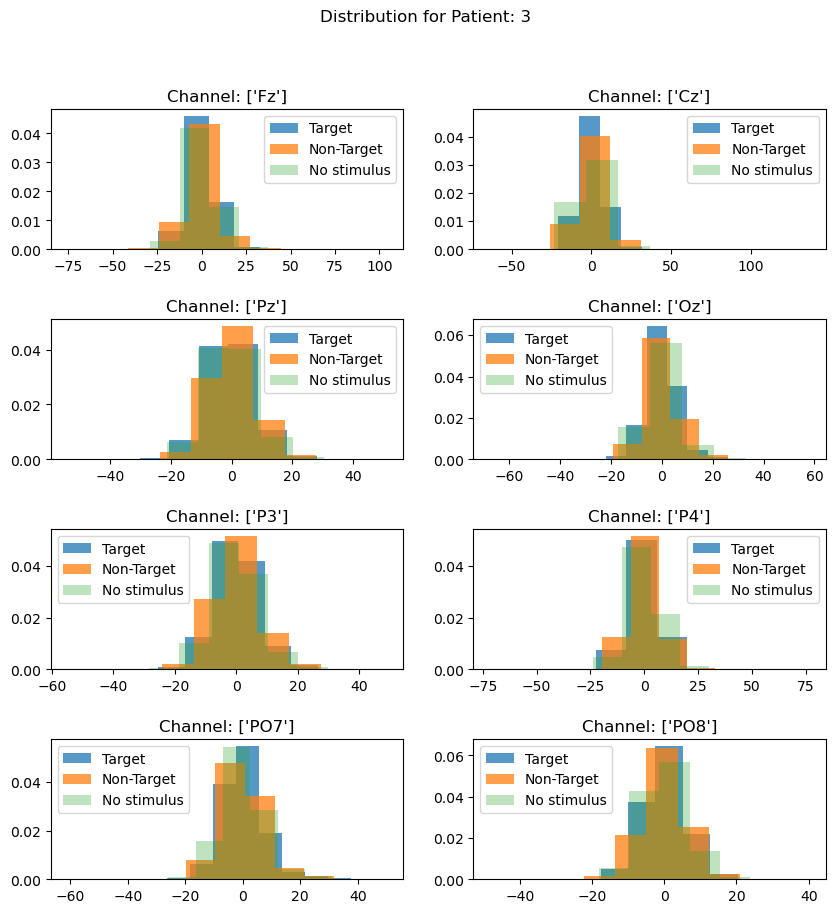

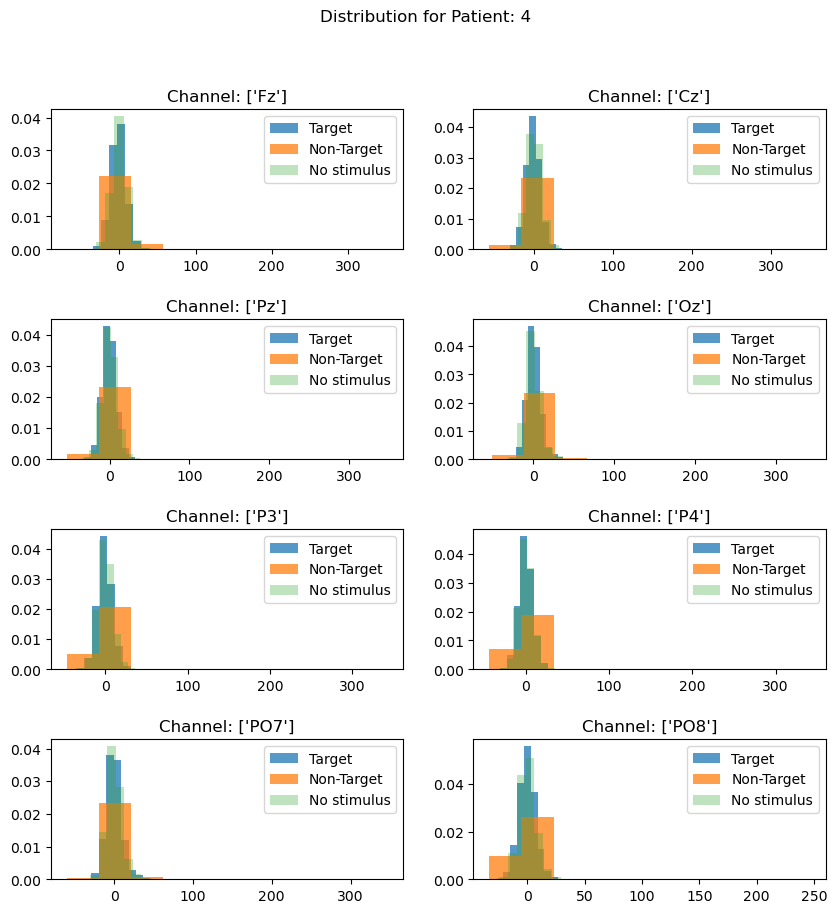

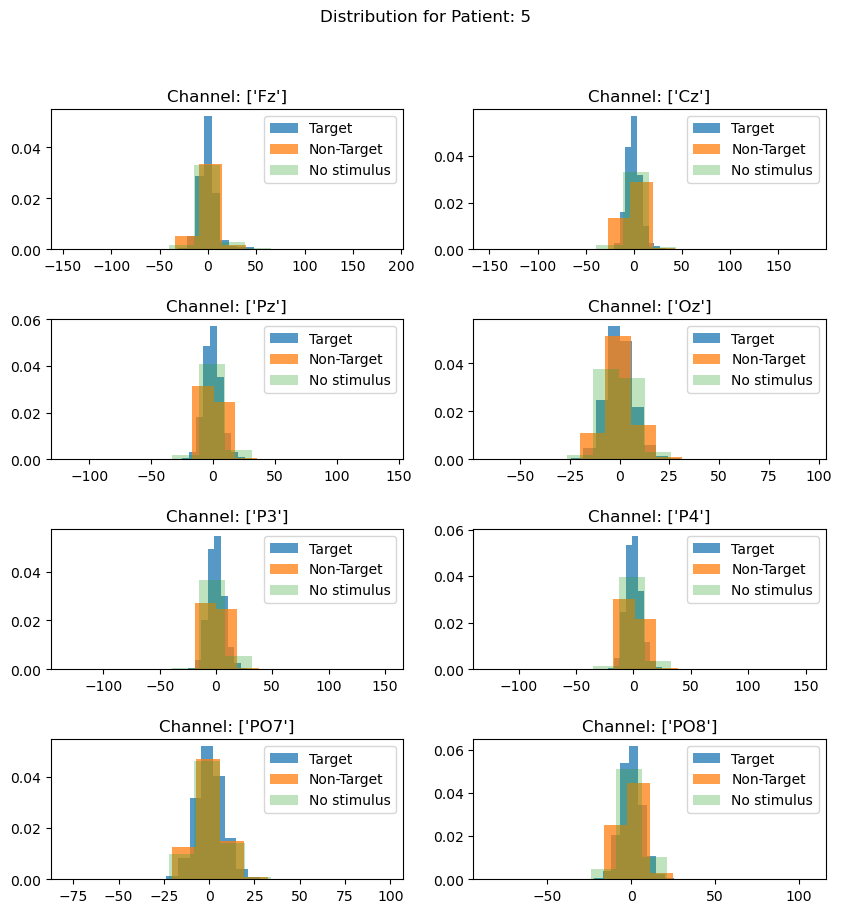

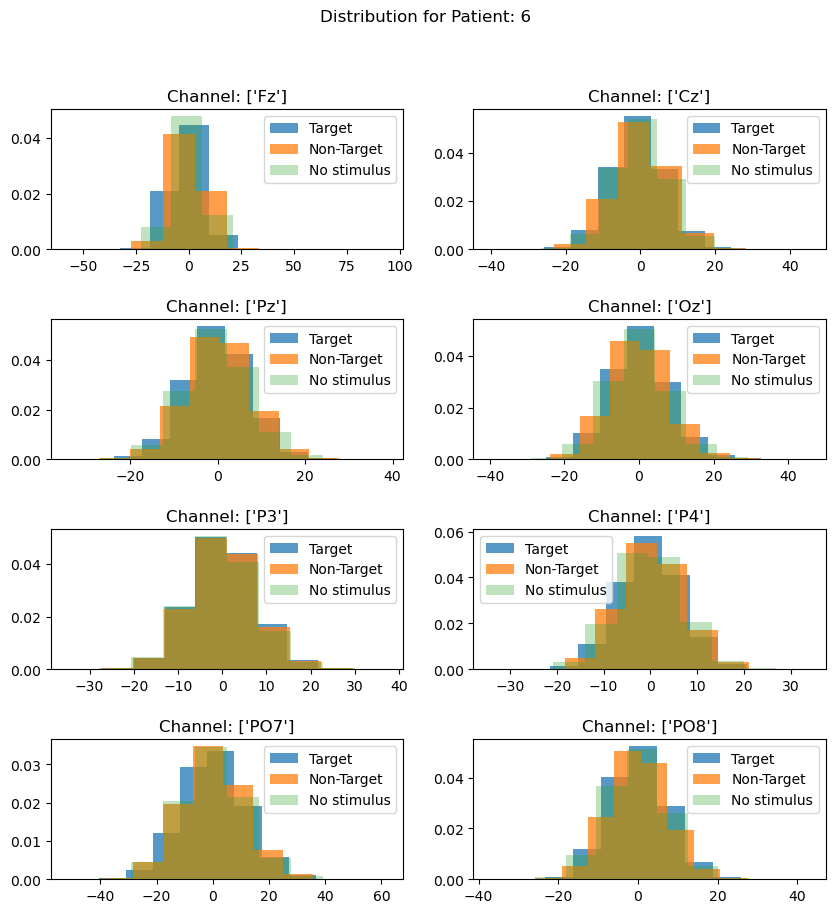

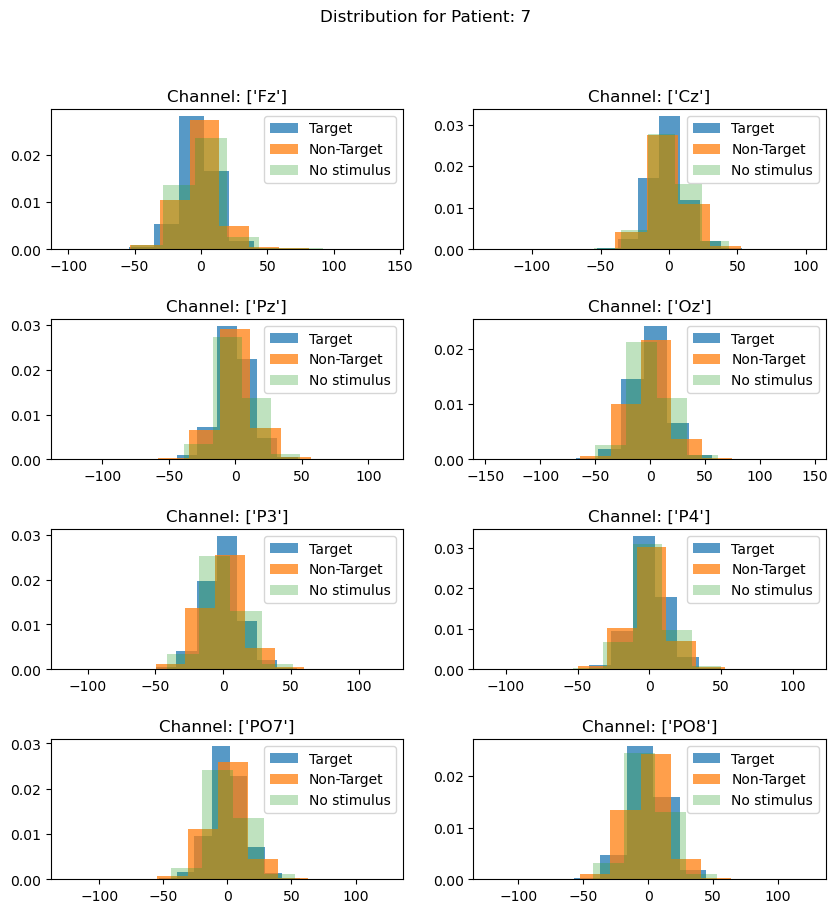

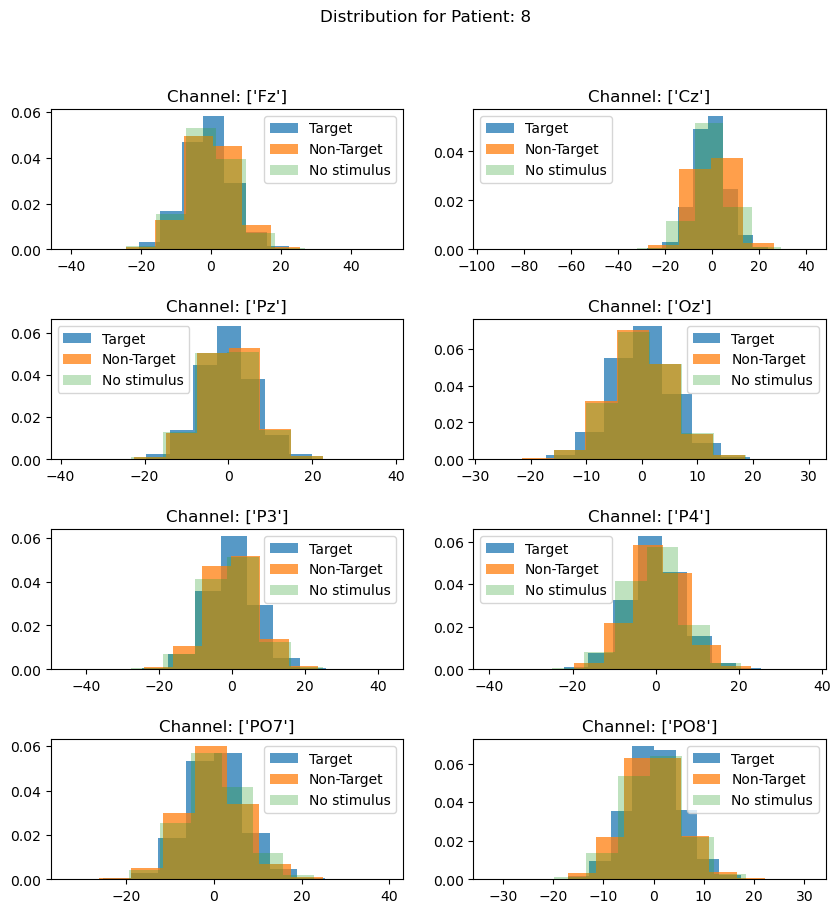

In [86]:
# Visualize channel output
cols = 2
rows = x.shape[-1]//cols
if int(rows) != rows:
    rows = int(rows) + 1
else:
    rows = int(rows)


for patient_id in range(x.shape[0]):
    current = 0
    fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
    for j in range(rows):
        for k in range(cols):
            x_channel = x[patient_id, :, :, :, current].reshape(-1)

            ax[j, k].set_title(f"Channel: {get_channel_name(patient_data[0], current)}")
            ax[j, k].hist(x_channel[y_target[patient_id].reshape(-1) == target_class], density=True, label='Target', alpha=0.75)
            ax[j, k].hist(x_channel[y_target[patient_id].reshape(-1) == non_target_class], density=True, label='Non-Target', alpha=0.75)      
            ax[j, k].hist(x_channel[y_target[patient_id].reshape(-1) == 0], density=True, label='No stimulus', alpha=0.3)      
            ax[j, k].legend()

            current += 1

    plt.subplots_adjust(hspace=0.5)
    plt.suptitle(f"Distribution for Patient: {patient_id+1}")
    plt.show()

We can see from the above distribution that indeed patient 2, 4, and 7 has a target-signal distribution with lower variance than their non-target counterpart. It is similar for almost all chnnels of those patients. Patients 3 and 8 shows similar behavior just in the 'Oz' channel. For other channels, the distribution is very similar. Furthermore, patients 1 and 6 do not show the same behavior. All distributions of all channels of these two patients are very similar. 

But we can also observe that for most cases, when no stimulus is provided, the distribution of the amplitude of the signals is similar to that of the distribution when target stimulus is provided.

### ALS Functional Rating Scale (ALSfrs)

The ALSFRS-R is a questionnaire-based scale that measures and tracks changes in a person's physical function over time.

Today, the ALSFRS-R is a widely used test in clinical trials to track ALS and is considered the gold standard measure of disability progression.

The ALSFRS was first developed and used in the 1990s, but since then has been revised and refined.

The ALSFRS-R measures 12 aspects of physical function, ranging from one’s ability to swallow and use utensils to climbing stairs and breathing. Each function is scored from 4 (normal) to 0 (no ability), with a maximum total score of 48 and a minimum total score of 0.

| Speech | Salivation | Swallowing |
| --- | --- | --- |
| Handwriting | Cutting food | Climbing stairs |
| Turning in bed | Walking | Dressing and Hygiene |
| Dyspnea (difficulty breathing) | Orthopnea (shortness of breath while lying down) | Breathing insufficiency |


Source: [https://www.alspathways.com/assessing-function/](https://www.alspathways.com/assessing-function/)

Let us take a look at the patient information:

In [41]:
for i in range(x.shape[0]):
    print(f"\nPatient {i+1}")
    print(f"Gender: {patient_data[i]['data'][0][0]['gender'][0]}")
    print(f"Age: {patient_data[i]['data'][0][0]['age'][0]}")
    print(f"ALS Functional rating scale: {patient_data[i]['data'][0][0]['ALSfrs'][0]}")
    print(f"ALS Onset Region: {patient_data[i]['data'][0][0]['onsetALS'][0]}")


Patient 1
Gender: male
Age: 55
ALS Functional rating scale: 13
ALS Onset Region: spinal

Patient 2
Gender: male
Age: 59
ALS Functional rating scale: 37
ALS Onset Region: spinal

Patient 3
Gender: male
Age: 43
ALS Functional rating scale: 33
ALS Onset Region: spinal

Patient 4
Gender: female
Age: 75
ALS Functional rating scale: 38
ALS Onset Region: bulbar

Patient 5
Gender: female
Age: 60
ALS Functional rating scale: 34
ALS Onset Region: bulbar

Patient 6
Gender: male
Age: 40
ALS Functional rating scale: 31
ALS Onset Region: Spinal

Patient 7
Gender: male
Age: 61
ALS Functional rating scale: 28
ALS Onset Region: Bulbar

Patient 8
Gender: Female
Age: 72
ALS Functional rating scale: 41
ALS Onset Region: Spinal


After analyzing the age, onset region, and ALSfrs of each patient we can see that there is nothing suggestive as to why some of the patients do not exhibit the same characteristics (low variance of target signals) as the mean distribution.

## Mean baseline substracted from squared amplitude

During each trial, the brain was performing many other task that was not related to the experiment. We can consider these activities as the baseline activity of the brain. If we can subtract this baseline activity from the signals that we obtained when the patient was viewing a target or a non-target stimulus, we can get a clearer picture of the signals involved in processing the stimulus.


We know that each patient had a break between two stimulus - known as inter-stimulus interval. In this period of time the patients were not expecting any stimulus. Therefore, we may use this as a baseline. However, since the amplitude values have both positive and negative values, calculating the mean may provide us zero i.e. no information. To solve this problem we can consider the square of amplitude and calculate the mean. 

We will lose some information performing this operation. Moreover, the positive and negative amplitudes of the signal will be considered equal. However, with this approach we can atleast estimate how much signal has an amplitude that is far away from zero when a patient is viewing either target or non-target stimulus.

To subtract the squared mean, we can square the target and non-target amplitudes and then subtract each value from the squared mean and then calculate the square root of the result.

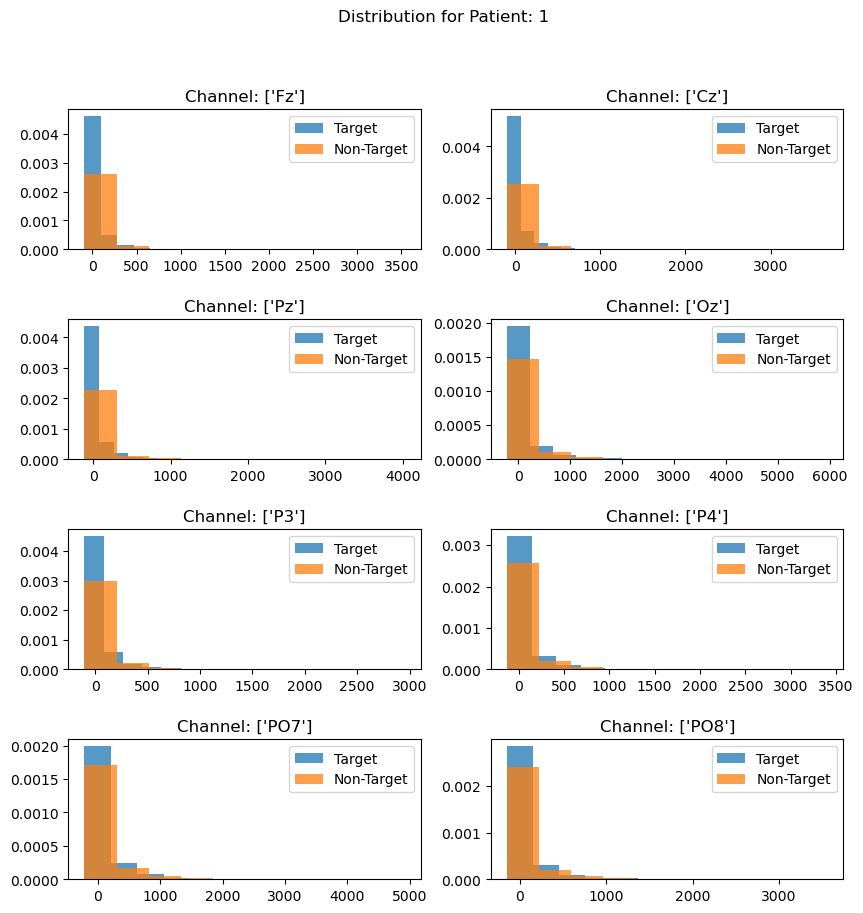

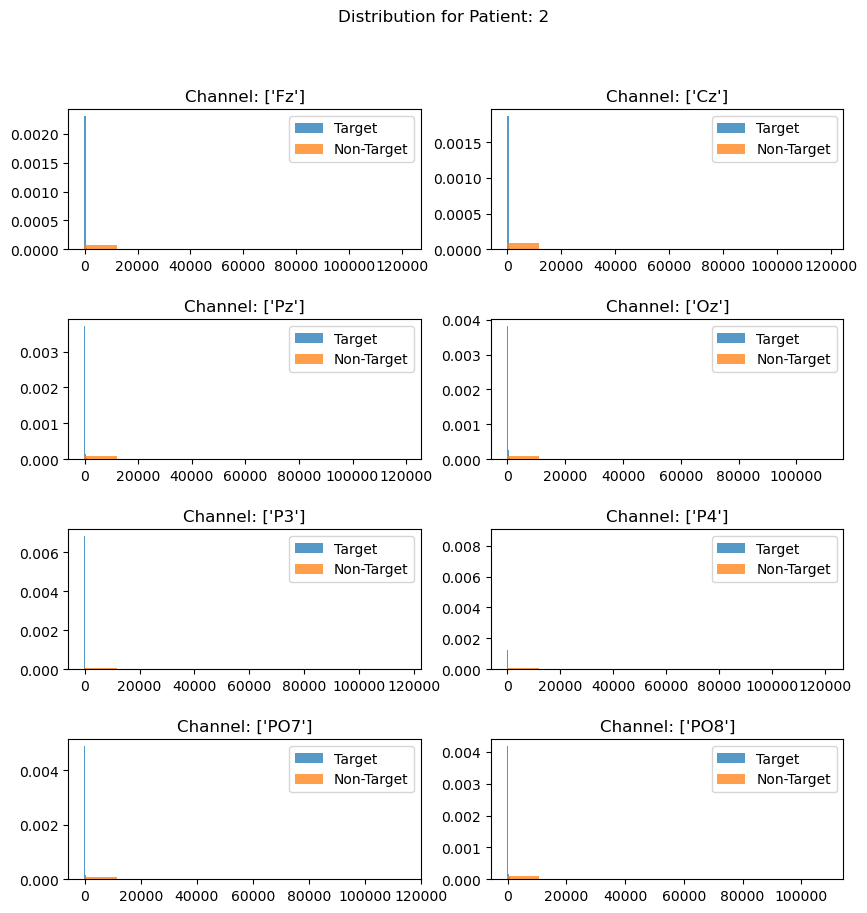

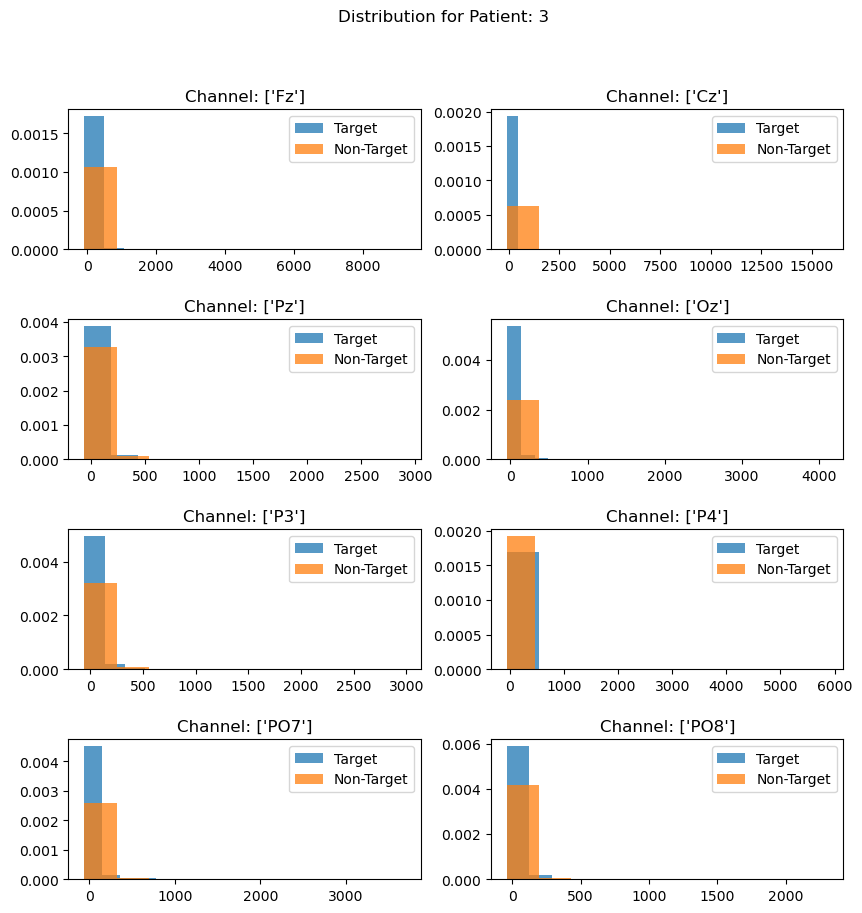

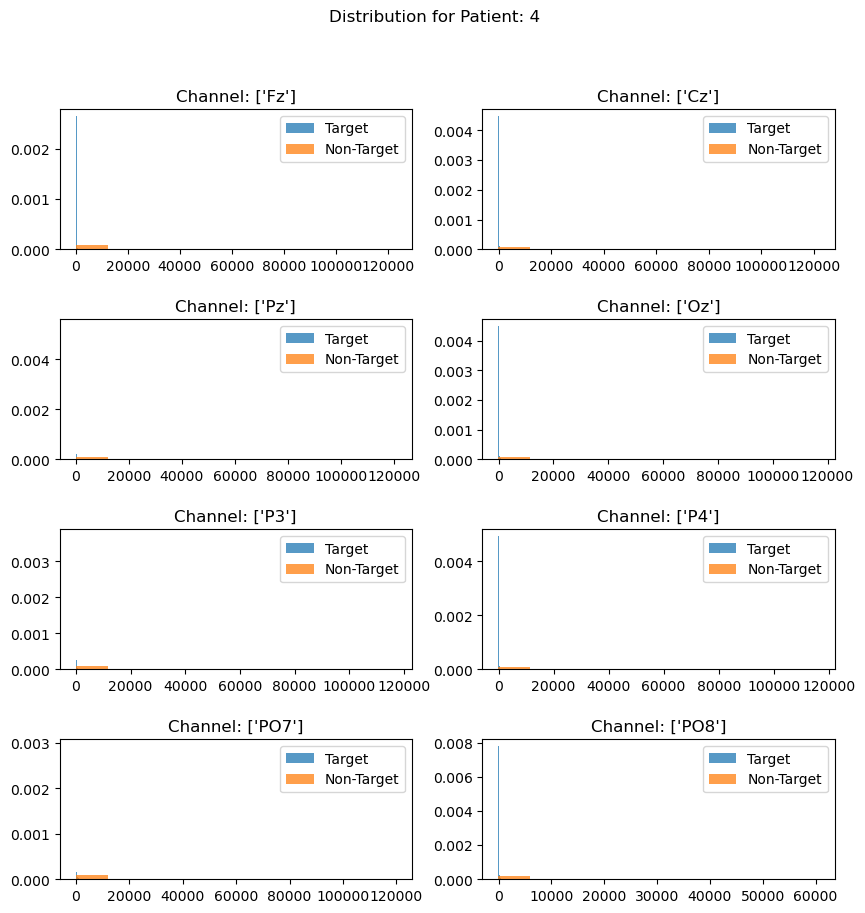

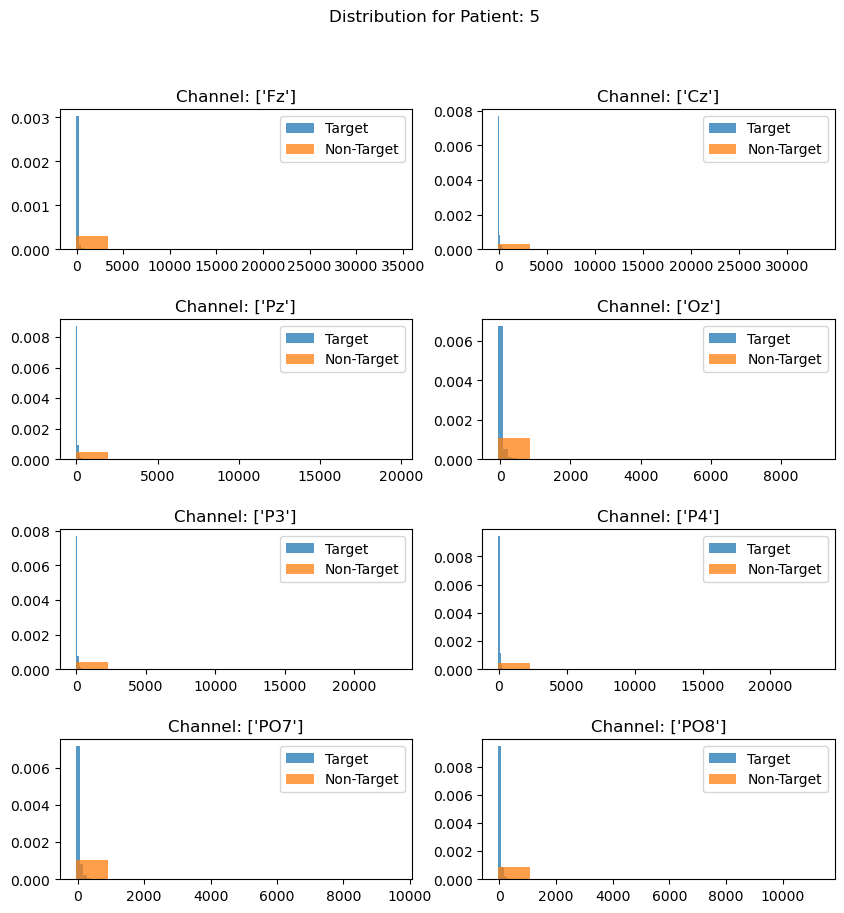

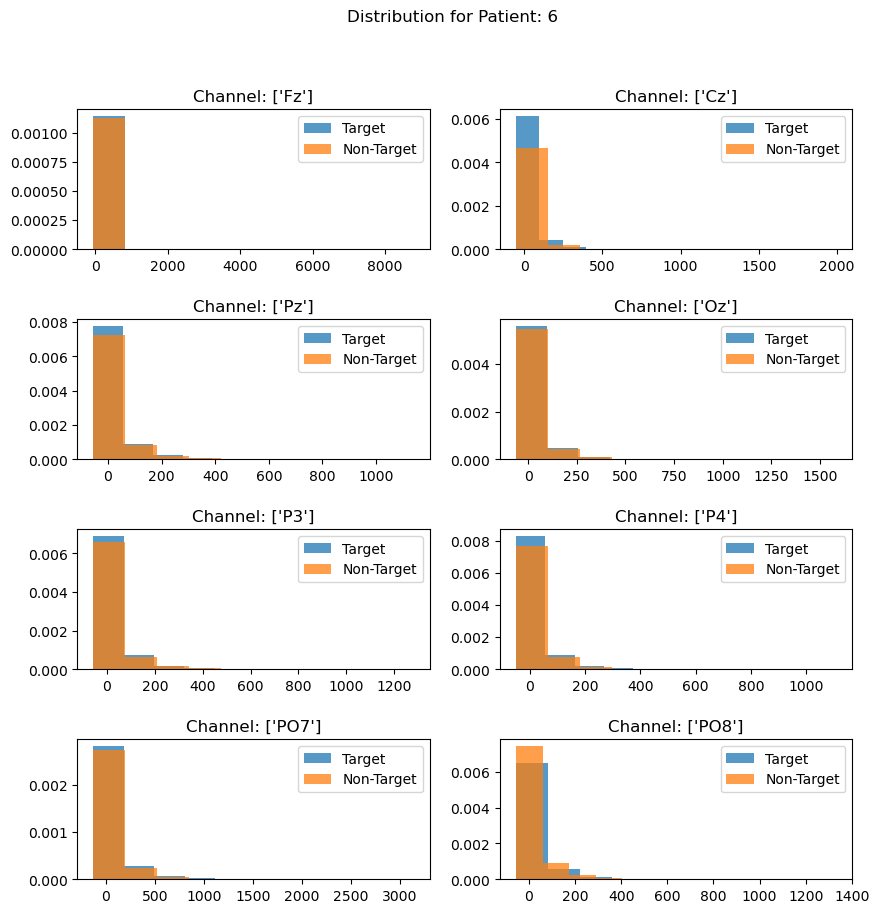

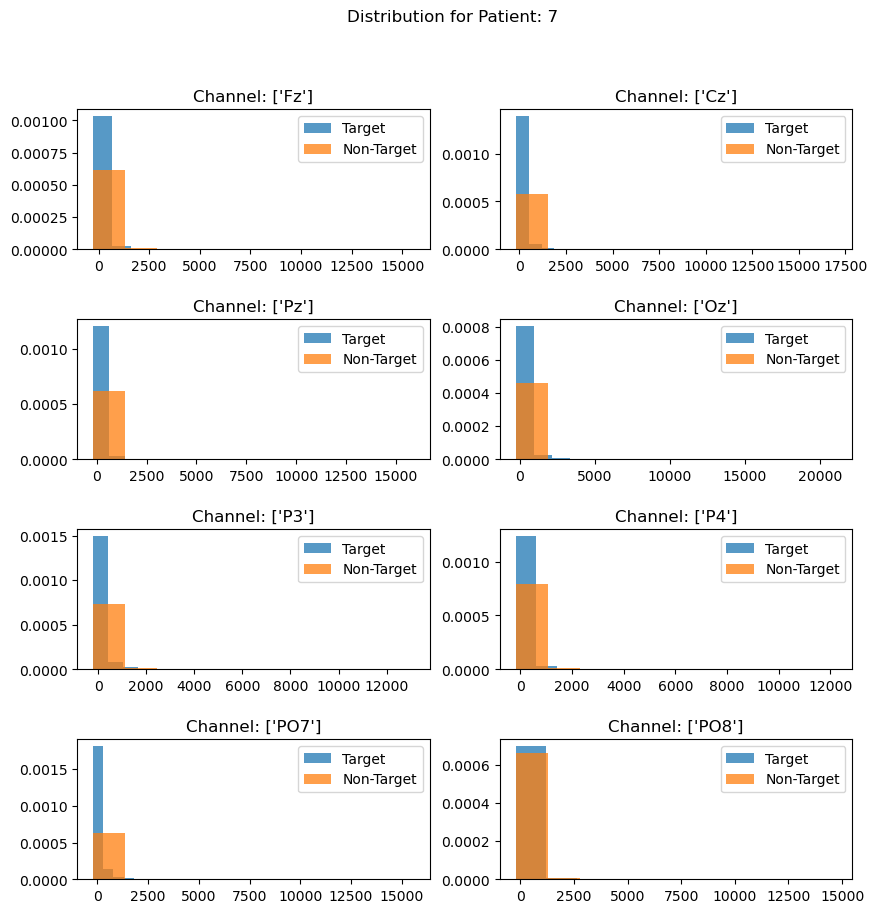

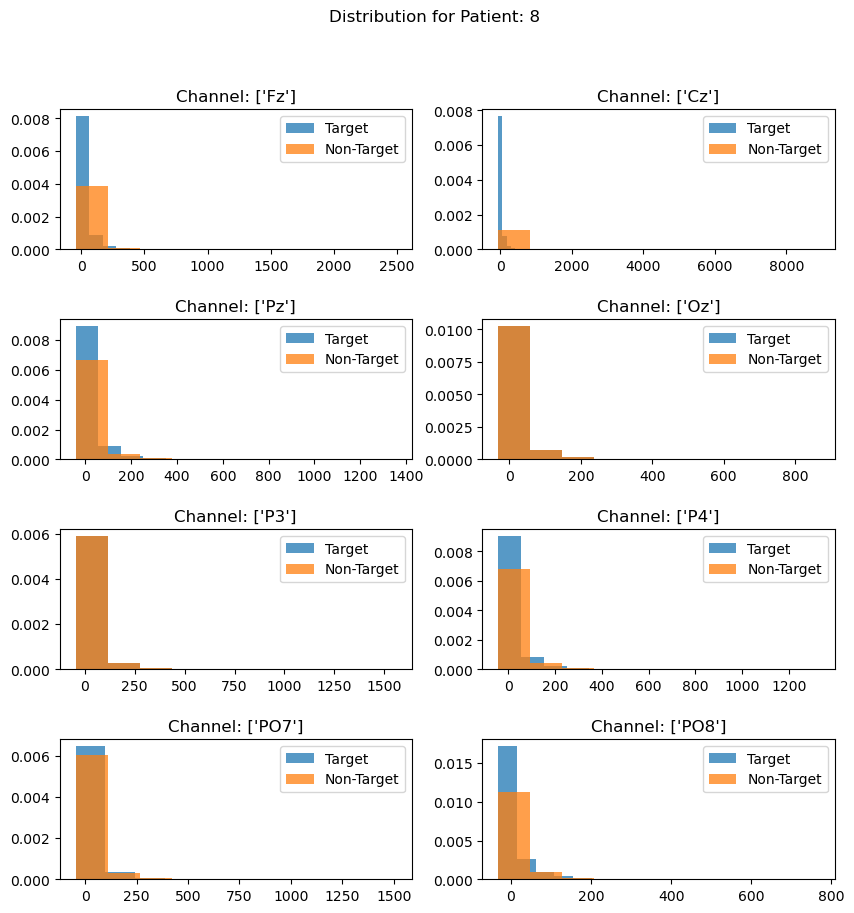

In [82]:
# Visualize channel output
cols = 2
rows = x.shape[-1]//cols
if int(rows) != rows:
    rows = int(rows) + 1
else:
    rows = int(rows)

for patient_id in range(x.shape[0]):
    current = 0
    fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
    for j in range(rows):
        for k in range(cols):
            x_channel = x[patient_id, :, :, :, current].reshape(-1)

            ax[j, k].set_title(f"Channel: {get_channel_name(patient_data[0], current)}")
            m = np.square(x_channel[y_target[patient_id].reshape(-1) == 0])
            m = np.mean(m)
            
            t = np.square(x_channel[y_target[patient_id].reshape(-1) == target_class])
            t = t - m
            ax[j, k].hist(t, density=True, label='Target', alpha=0.75)
            
            nt = np.square(x_channel[y_target[patient_id].reshape(-1) == non_target_class])
            nt = nt - m
            ax[j, k].hist(nt, density=True, label='Non-Target', alpha=0.75)      
            ax[j, k].legend()

            current += 1

    plt.subplots_adjust(hspace=0.5)
    plt.suptitle(f"Distribution for Patient: {patient_id+1}")
    plt.show()

When we calculate the distribution of squared amplitude (without subtracting the mean baseline), we can see a similar distribution. This tells us that during a target stimulus most of the amplitude values are near zero whereas during a non-target stimulus the amplitude can vary.

# Signal Waveform Analysis - Channel Specific

First let us plot the average waveform of target and non-target signal for each channel

In [287]:
def collect_waveform_for_each_stimulus_category(x, y, show_progress=False, get_delayed_samples=0):
    """
    Input shape: (run, trial, sample, channel), (run, trial, sample)
    Output shape: {
        channel: {
            channel: [samples]
        }
    }
    """
    output = {
        target_class: {i: [] for i in range(x.shape[-1])},
        non_target_class: {i: [] for i in range(x.shape[-1])},
        0: {i: [] for i in range(x.shape[-1])},
    }
    if get_delayed_samples < 0:
        get_delayed_samples = 0
        
    
    x = x.reshape(-1, x.shape[-1])
    y = y.reshape(-1)
    
    if get_delayed_samples > 0:
        x = np.concatenate( (np.ones((get_delayed_samples, x.shape[1]), dtype='<f8')* x[0, :], x, np.ones((get_delayed_samples, x.shape[1]), dtype='<f8')* x[-1, :])  )
        y = np.concatenate( (np.ones((get_delayed_samples,), dtype='<i2')* y[0], y, np.ones((get_delayed_samples,), dtype='<i2')* y[-1])  )
        
    sequences = []
    current_sequence = [0]
    if get_delayed_samples > 0:
        current_sequence = [i for i in range(get_delayed_samples+1)]
    last_value = y[current_sequence[-1]]
    
   
    
    added_delayed_samples = 0    
    start_adding_delayed_samples = False
    vals = range(1+get_delayed_samples, y.shape[0] - get_delayed_samples, 1)
    if show_progress:
        vals = tqdm(vals)
    for i in vals:
        # If sequence is continuing
        if y[i] == last_value:
            current_sequence.append(i) # Add to current sequence
        else:
            # Sequence has ended. Add current sequence to list of sequences and start a new sequence
            added_delayed_samples = 0
            start_adding_delayed_samples = True
            sequences.append(current_sequence)
            if get_delayed_samples > 0:
                sequences[-1] += [j for j in range(i, i+get_delayed_samples, 1)]
                current_sequence = [j for j in range(i-get_delayed_samples,i+1)]
            else:
                current_sequence = [i]

                
        last_value = y[i]
            
    if len(current_sequence) > 0:
        sequences.append(current_sequence)
        if get_delayed_samples > 0:
            sequences[-1] += [j for j in range(current_sequence[-1], current_sequence[-1]+get_delayed_samples, 1)]
    
    vals = range(x.shape[1])
    if show_progress:
        vals = tqdm(vals)
    for i in vals:
        for j in range(len(sequences)):
            sequence = sequences[j]
            current_target = y[sequence[get_delayed_samples]]
            output[current_target][i].append(x[sequence, i].tolist())
    return output
            

In [289]:
waveforms = collect_waveform_for_each_stimulus_category(x[0], y_target[0], show_progress=True)
waveforms = collect_waveform_for_each_stimulus_category(x[0], y_target[0], show_progress=True, get_delayed_samples=30)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.66it/s]


In [290]:
def get_padded_signals(signals):
    max_length = np.max([len(signals[i]) for i in range(len(signals))])
    result = []
    for i in range(len(signals)):
        l = len(signals[i])
        if l > max_length:
            signals[i]  = signals[i][:max_length]
        elif l < max_length:
            diff = max_length - l
            signals[i] = signals[i] + [0 for _ in range(diff)]
        result.append(signals[i])
    return np.array(result)

In [291]:
padded_signals = np.mean(get_padded_signals(waveforms[0][7]), axis=0)
print(padded_signals.shape)

(92,)


## Plotting Average Waveform for each channel

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.05s/it]


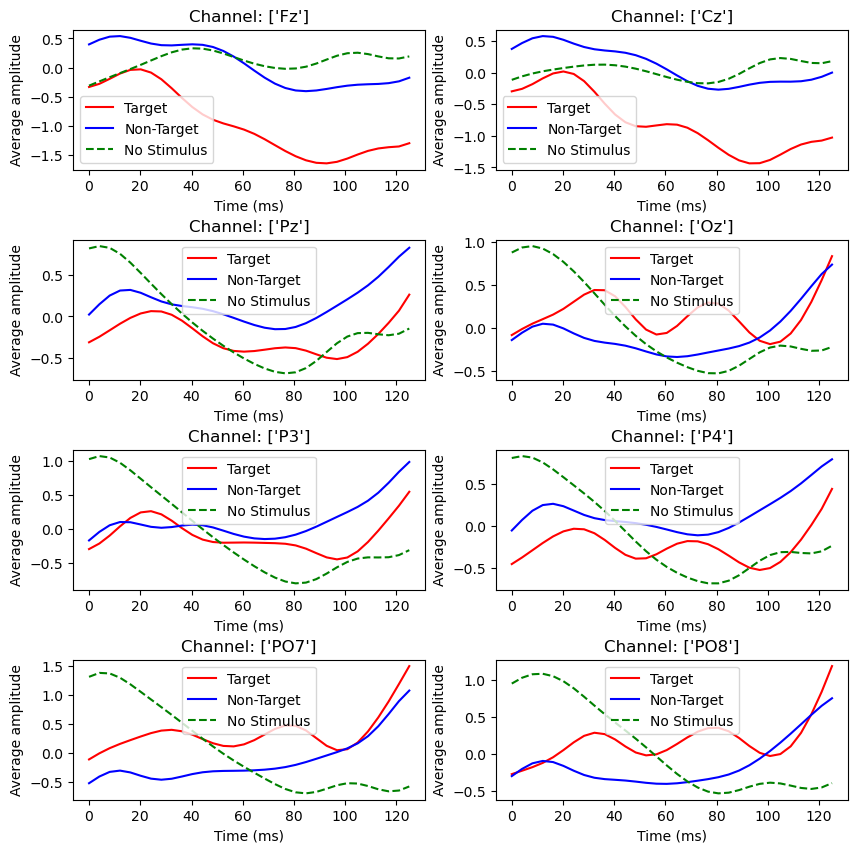

In [292]:

mt_average = [None for _ in range(x.shape[-1])]
nt_average = [None for _ in range(x.shape[-1])]
ns_average = [None for _ in range(x.shape[-1])]

# Visualize channel output
for i in tqdm(range(x.shape[0])):
    cols = 2
    rows = x.shape[-1]//cols
    if int(rows) != rows:
        rows = int(rows) + 1
    else:
        rows = int(rows)
        
        
#     fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
#     plt.suptitle(f"Patient: {i+1}")
    waveforms = collect_waveform_for_each_stimulus_category(x[i], y_target[i])
    for j in range(x.shape[-1]):    
        if mt_average[j] is None:
            mt_average[j] = np.mean(get_padded_signals(waveforms[target_class][j]), axis=0)
        else:
            mt_average[j] = np.mean(get_padded_signals([mt_average[j], np.mean(get_padded_signals(waveforms[target_class][j]), axis=0)]), axis=0)
            
        if nt_average[j] is None:
            nt_average[j] = np.mean(get_padded_signals(waveforms[non_target_class][j]), axis=0)
        else:
            nt_average[j] = np.mean(get_padded_signals([nt_average[j], np.mean(get_padded_signals(waveforms[non_target_class][j]), axis=0)]), axis=0)
            
        if ns_average[j] is None:
            ns_average[j] = np.mean(get_padded_signals(waveforms[0][j]), axis=0)
        else:
            ns_average[j] = np.mean(get_padded_signals([ns_average[j], np.mean(get_padded_signals(waveforms[0][j]), axis=0)]), axis=0)
        
        


fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
current = 0
for j in range(rows):
    for k in range(cols):
        max_val = np.max([mt_average[current].size, nt_average[current].size, ns_average[current].size])
        counts = np.arange(max_val)
        x_axis = np.linspace(0, 1000*max_val/sample_frequency, counts.size)

        ax[j, k].set_title(f"Channel: {get_channel_name(patient_data[0], current)}")
        ax[j, k].plot(x_axis, mt_average[current], 'r-', label='Target')
        ax[j, k].plot(x_axis, nt_average[current], 'b-', label='Non-Target')
        ax[j, k].plot(x_axis, ns_average[current], 'g--', label='No Stimulus')
        
        ax[j, k].set_xlabel("Time (ms)")
        ax[j, k].set_ylabel("Average amplitude")
        ax[j, k].legend()
        
        current += 1
        
plt.subplots_adjust(hspace=0.5)
plt.show()

Each stimulus is presented for 125 ms. Therefore, we grouped all sequence of consecutive signals that belong to the same stimulus category. For example if the signals are:

\[1, 2, 3, 4, 5, 6\]

and the stimulus is 

\[1, 1, 0, 0, 2, 2\]

We grouped each sequence of signal to create a waveform as follows:

- Stimulus type 1: \[1, 2\]
- Stimulus type 0: \[3, 4\]
- Stimulus type 2: \[5, 6\]

In this way we collected each waveform for each channel and patient. We then averaged the waveforms acrosss patient for each category and channel. As a result we obtained the above graph where we can see how neurons in each channel respond when they receive a target/non-target stimulus and when it does not receive any stimulus.

### Parieto-Occipital (left and right) & Midline Occipital region

We can see that in the regions 'PO7', 'PO8', and 'Oz', the waveform has a sharp increase at around 100 ms. On the other hand, when a non-target is provided it increases a little gradually. Moreover, in absence of a stimulus, the activity in this region gradually decreases.

We know that these regions are responsible for visual perception, spatial attention, object recognition, etc. So, we can assume that the sharp increase in the amplitude occurred when the patient recognized the target stimulus.


### Parietal Region (P3, P4, and Pz)

From the above graph we can see that the regions P3, P4, and Pz also shows a sharp rise in amplitude around 100ms when a target stimulus is presented. However, the overall amplitude is less than the non-target signal. It may be due the fact that these regions are near 'PO7', 'PO8', and 'Oz' and as a result is picking up some signal from this region.


## Plotting Average Waveform for each channel and patient

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

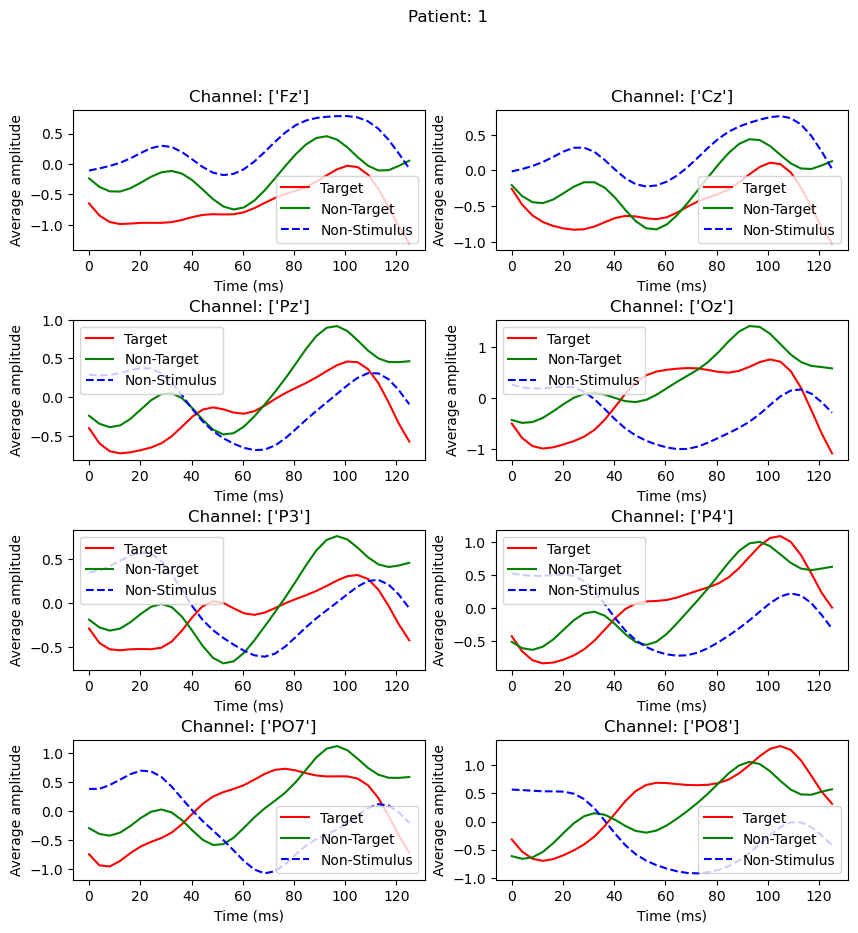

 12%|██████████▌                                                                         | 1/8 [00:01<00:10,  1.52s/it]

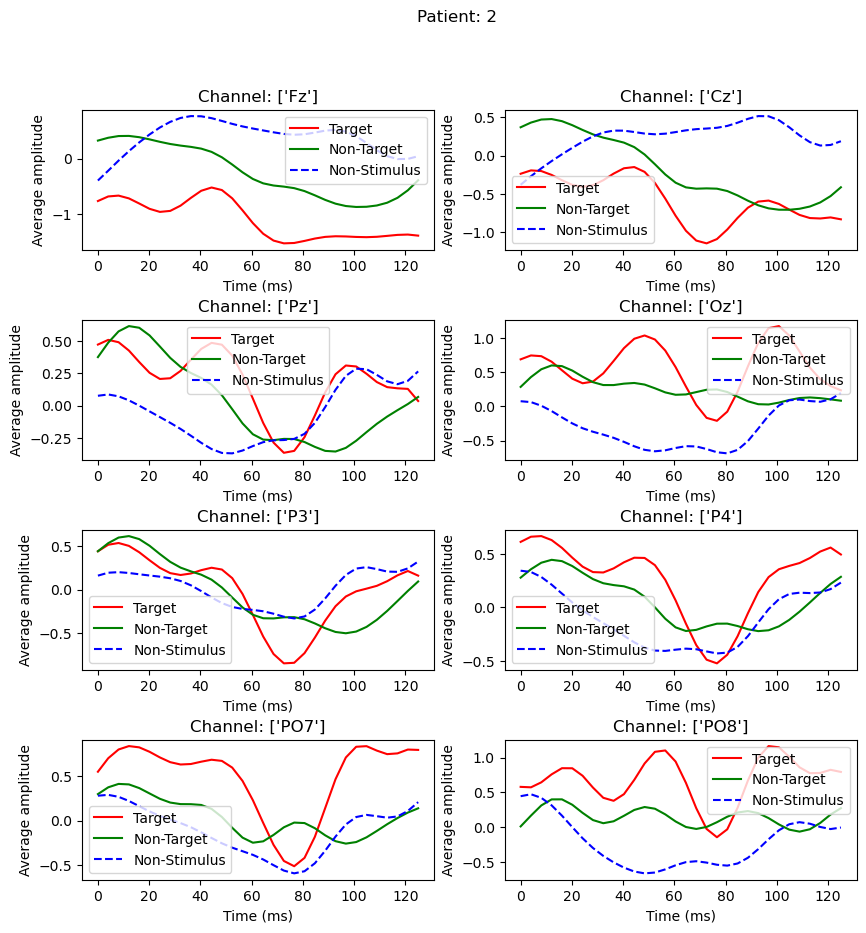

 25%|█████████████████████                                                               | 2/8 [00:03<00:10,  1.73s/it]

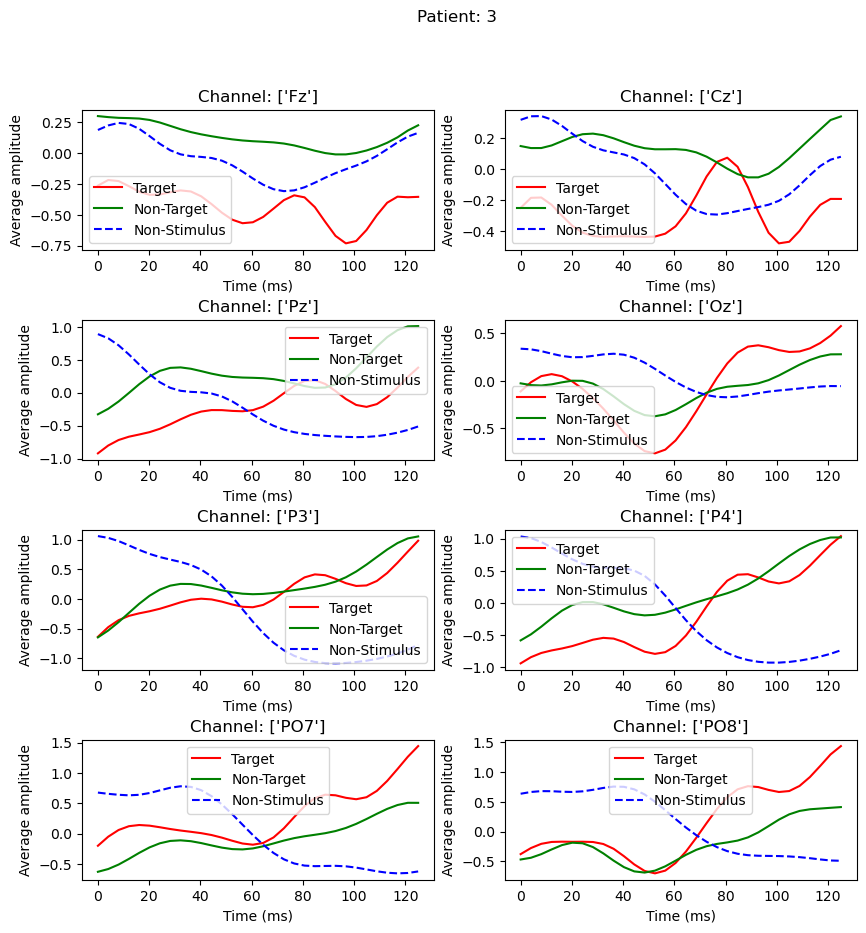

 38%|███████████████████████████████▌                                                    | 3/8 [00:04<00:08,  1.64s/it]

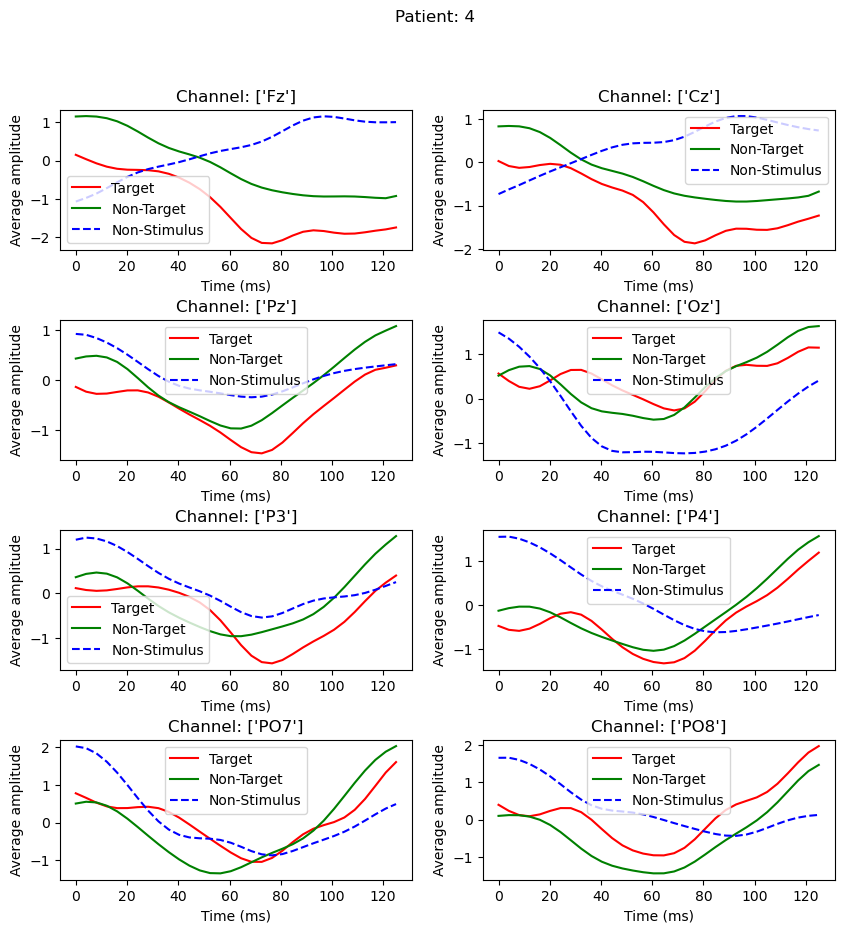

 50%|██████████████████████████████████████████                                          | 4/8 [00:06<00:06,  1.71s/it]

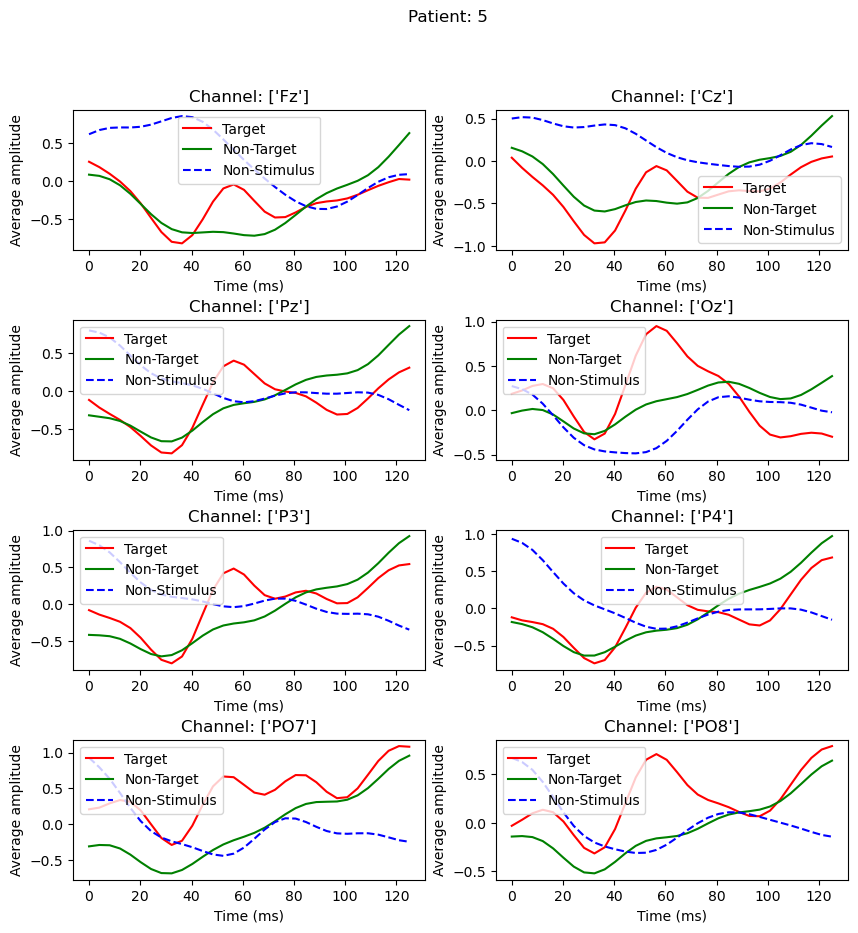

 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:08<00:04,  1.64s/it]

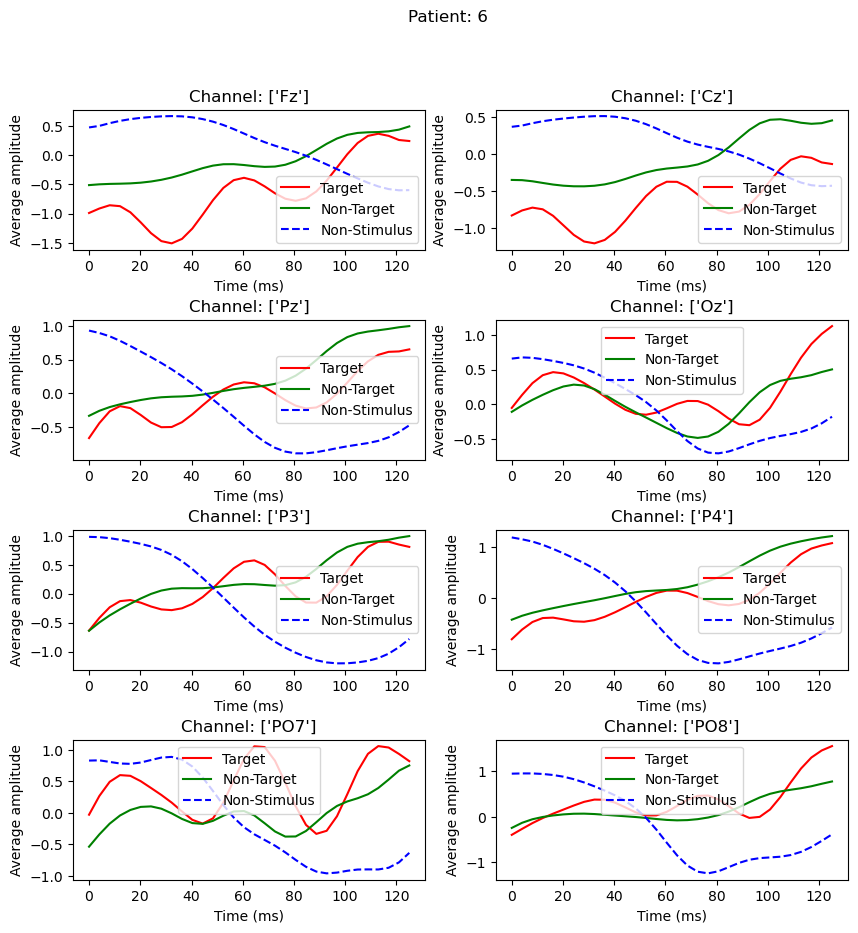

 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:10<00:03,  1.74s/it]

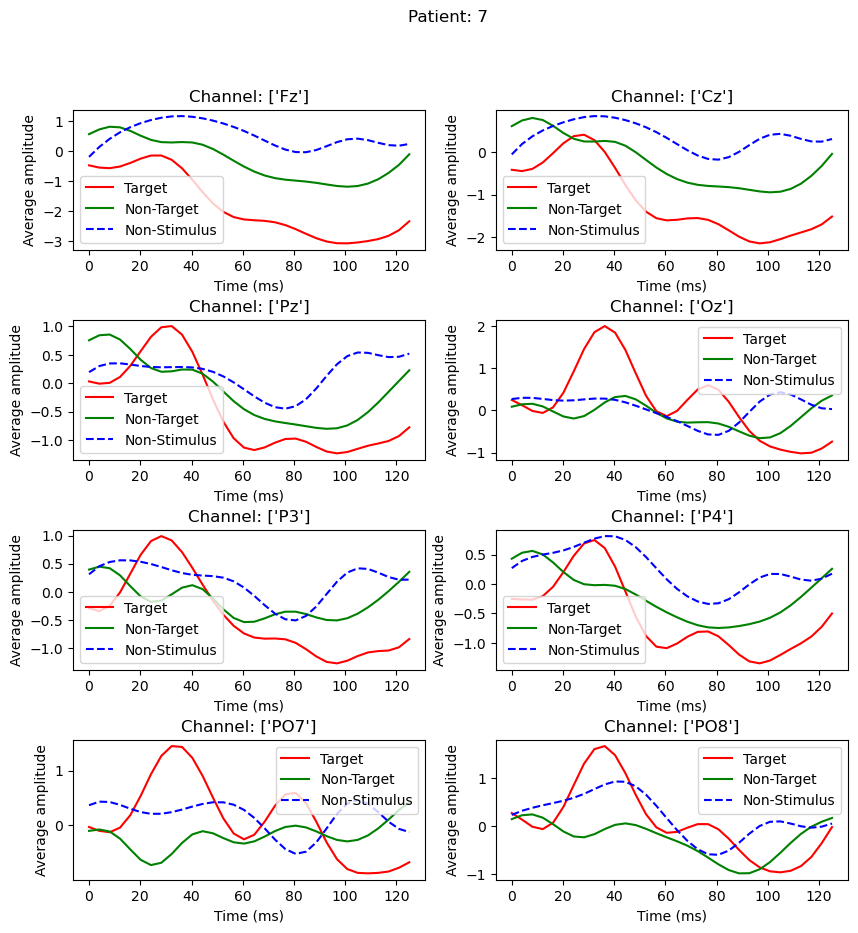

 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:11<00:01,  1.67s/it]

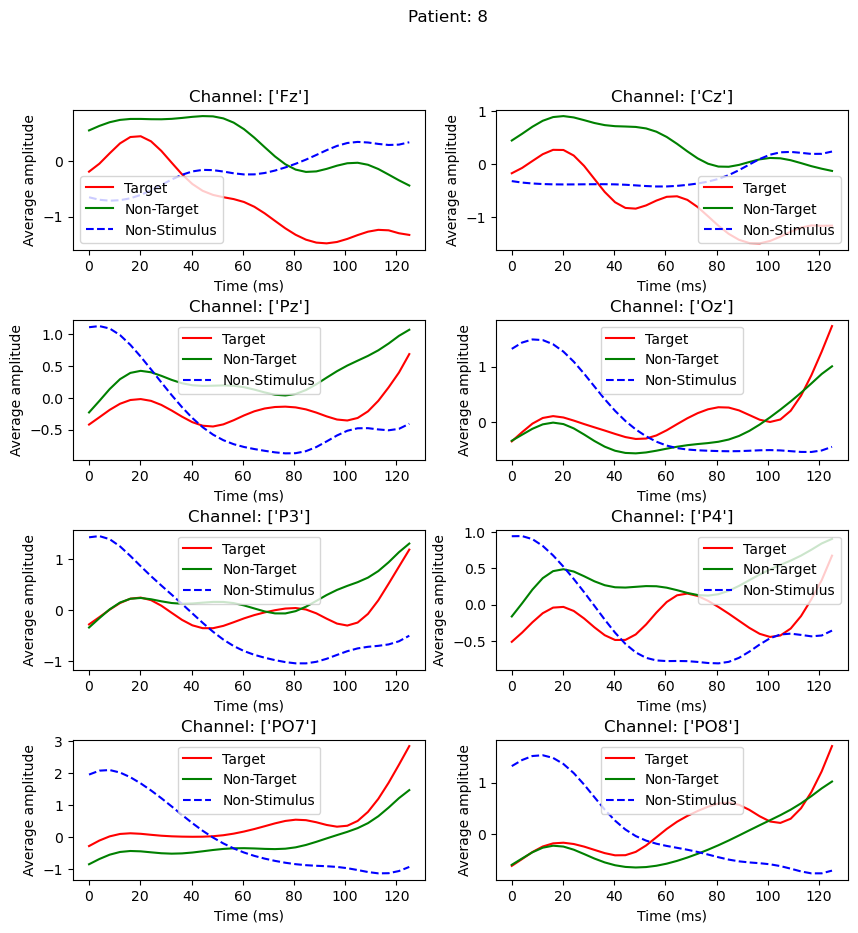

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:13<00:00,  1.69s/it]


In [310]:

        
# Visualize channel output
for i in tqdm(range(x.shape[0])):
    cols = 2
    rows = x.shape[-1]//cols
    if int(rows) != rows:
        rows = int(rows) + 1
    else:
        rows = int(rows)
        
        
    fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
    plt.suptitle(f"Patient: {i+1}")
    current = 0
    waveforms = collect_waveform_for_each_stimulus_category(x[i], y_target[i])
    for j in range(rows):
        for k in range(cols):
            ax[j, k].set_title(f"Channel: {get_channel_name(patient_data[i], current)}")
            
            mt = np.mean(get_padded_signals(waveforms[target_class][current]), axis=0)
            nt = np.mean(get_padded_signals(waveforms[non_target_class][current]), axis=0)
            ns = np.mean(get_padded_signals(waveforms[0][current]), axis=0)
            
            max_val = np.max([mt.size, nt.size, ns.size])
            counts = np.arange(max_val)
            x_axis = np.linspace(0, 1000*max_val/sample_frequency, counts.size)            
            
            
            ax[j, k].plot(x_axis, mt, 'r-', label='Target')                     
            ax[j, k].plot(x_axis, nt, 'g-', label='Non-Target')            
            ax[j, k].plot(x_axis, ns, 'b--', label='Non-Stimulus')
            
            
            ax[j, k].set_xlabel("Time (ms)")
            ax[j, k].set_ylabel("Average amplitude")
            
            current += 1
            
            ax[j, k].legend()
    plt.subplots_adjust(hspace=0.5)
    plt.show()

### Target Stimulus

From the above graph, for each patient we can see that the waveforms in the parietal region does start increasing exponentially after around 50-80 ms. The following were observed for waveforms related to target stimulus:

**Patient 1**

There is an increase of amplitude in parietal region at around 20-40ms and then the amplitude decreases sharply at around 80-100 ms.

At frontal region there is a gradual increase of amplitude and a sharp decrease at around 80-100 ms.


**Patient 2**

There is a slight increase in amplitude at parietal region at around 30-40 ms followed by a decrease in amplitude and then a sharp rise at around 60-80 ms.

At frontal region, there is a slight increase at around 30 ms and then a decrease in amplitude is observed.

**Patient 3**

At parietal region there is a sharp increase at 40-60 ms followed by another slight increase at around 100 ms.  

The frontal region shows a slight increase at around 50-60 ms.

**Patient 4**

A sharp increase in parietal region is observed at around 70-80 ms. 

The frontal region shows a decrease in amplitude at around 40-50 ms.

**Patient 5**

In parietal region there is a sharp increase at around 30-40 ms followed by a decrease and then an increase again at around 90-100 ms. 

The frontal region shows an increase in amplitude at around 30-40 ms.

**Patient 6**

The parietal region shows a slight increase at around 30-60 ms followed by a sharp increase at around 90-100 ms. 

The frontal region shows an increase in amplitude at around 30-40 ms and the again at 80-90 ms.

**Patient 7**

At parietal region a sharp increase in amplitude is observed at around 10-20 ms followed by a decrease and then a slight increase after 100 ms.

At frontal region an increase is observed at around 10-20 ms followed by a decrease in amplitude.

**Patient 8**

A sharp increase of amplitude is observed at around 100-110 ms in the parietal region with slight increase before it at around 40-50 ms. 

The frontal region shows an increase in amplitude at around 10-20 ms followed by a decrease.


Generally, we can observe two peaks in different channels of the parietal region when a target stimulus is provided. The first one is somewhere around 30-60 ms and the second one is around 80-100 ms. These two peaks have a decrease in amplitude between them. 

The frontal region generally shows a decrease in amplitude (except patient 5 and 6) between the duration 30-70 ms. Patient 5 and 6 shows an increase in the amplitude of signal in frontal region at almost the same time when the amplitude of parietal region starts increasing.

#### Non-target stimulus

The non-target stimulus also shows an increase in amplitude at around 40-60 ms but generally it has fewer peaks and valeys. The change is gradual.

In [173]:
for i in range(x.shape[0]):
    print(f"\nPatient {i+1}")
    print(f"Gender: {patient_data[i]['data'][0][0]['gender'][0]}")
    print(f"Age: {patient_data[i]['data'][0][0]['age'][0]}")
    print(f"ALS Functional rating scale: {patient_data[i]['data'][0][0]['ALSfrs'][0]}")
    print(f"ALS Onset Region: {patient_data[i]['data'][0][0]['onsetALS'][0]}")


Patient 1
Gender: male
Age: 55
ALS Functional rating scale: 13
ALS Onset Region: spinal

Patient 2
Gender: male
Age: 59
ALS Functional rating scale: 37
ALS Onset Region: spinal

Patient 3
Gender: male
Age: 43
ALS Functional rating scale: 33
ALS Onset Region: spinal

Patient 4
Gender: female
Age: 75
ALS Functional rating scale: 38
ALS Onset Region: bulbar

Patient 5
Gender: female
Age: 60
ALS Functional rating scale: 34
ALS Onset Region: bulbar

Patient 6
Gender: male
Age: 40
ALS Functional rating scale: 31
ALS Onset Region: Spinal

Patient 7
Gender: male
Age: 61
ALS Functional rating scale: 28
ALS Onset Region: Bulbar

Patient 8
Gender: Female
Age: 72
ALS Functional rating scale: 41
ALS Onset Region: Spinal


If we observe the average waveform for the channels **Oz, PO7, PO8** again but this time crop the waveform so that we view the waveforms starting from 60th ms then we get the following graph:

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.01s/it]


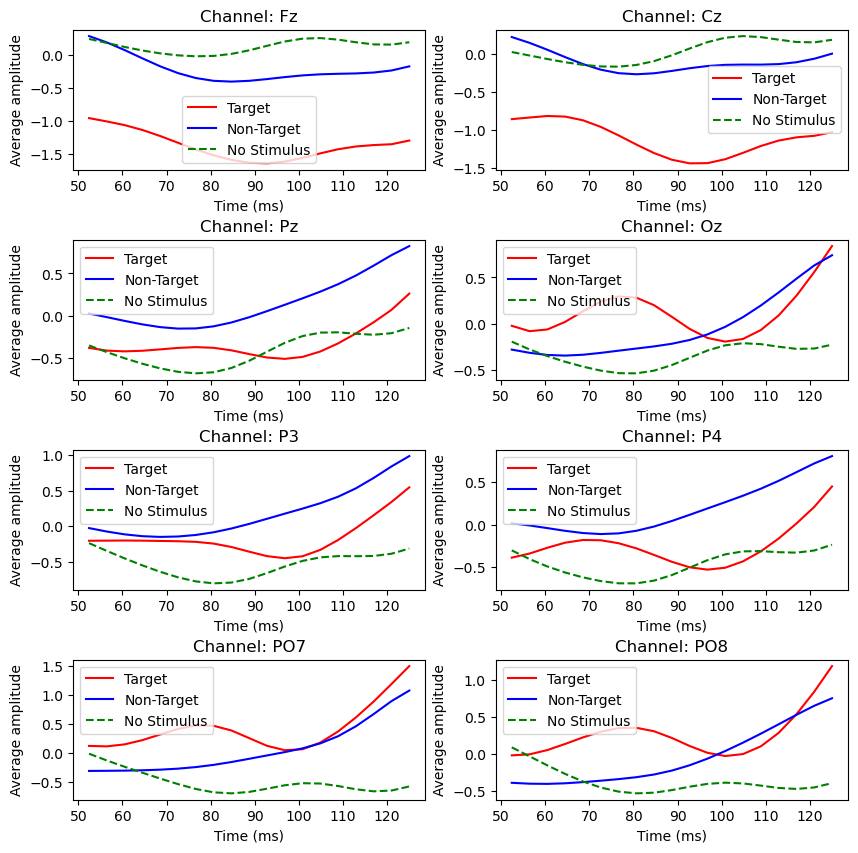

In [294]:

mt_average = [None for _ in range(x.shape[-1])]
nt_average = [None for _ in range(x.shape[-1])]
ns_average = [None for _ in range(x.shape[-1])]

# Visualize channel output
for i in tqdm(range(x.shape[0])):
    cols = 2
    rows = x.shape[-1]//cols
    if int(rows) != rows:
        rows = int(rows) + 1
    else:
        rows = int(rows)
        
#     fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
#     plt.suptitle(f"Patient: {i+1}")
    waveforms = collect_waveform_for_each_stimulus_category(x[i], y_target[i])
    for j in range(x.shape[-1]):    
        if mt_average[j] is None:
            mt_average[j] = np.mean(get_padded_signals(waveforms[target_class][j]), axis=0)
        else:
            mt_average[j] = np.mean(get_padded_signals([mt_average[j], np.mean(get_padded_signals(waveforms[target_class][j]), axis=0)]), axis=0)
            
        if nt_average[j] is None:
            nt_average[j] = np.mean(get_padded_signals(waveforms[non_target_class][j]), axis=0)
        else:
            nt_average[j] = np.mean(get_padded_signals([nt_average[j], np.mean(get_padded_signals(waveforms[non_target_class][j]), axis=0)]), axis=0)
            
        if ns_average[j] is None:
            ns_average[j] = np.mean(get_padded_signals(waveforms[0][j]), axis=0)
        else:
            ns_average[j] = np.mean(get_padded_signals([ns_average[j], np.mean(get_padded_signals(waveforms[0][j]), axis=0)]), axis=0)
        
        


fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
current = 0
crop_duration = 50 #ms
for j in range(rows):
    for k in range(cols):
        max_val = np.max([mt_average[current].size, nt_average[current].size, ns_average[current].size])
        counts = np.arange(max_val)
        x_axis = np.linspace(0, 1000*max_val/sample_frequency, counts.size)
        indices = np.where(x_axis >= crop_duration)[0]

        ax[j, k].set_title(f"Channel: {get_channel_name(patient_data[0], current)[0]}")
        ax[j, k].plot(x_axis[indices], mt_average[current][indices], 'r-', label='Target')
        ax[j, k].plot(x_axis[indices], nt_average[current][indices], 'b-', label='Non-Target')
        ax[j, k].plot(x_axis[indices], ns_average[current][indices], 'g--', label='No Stimulus')

        ax[j, k].set_xlabel("Time (ms)")
        ax[j, k].set_ylabel("Average amplitude")
        ax[j, k].legend()

        current += 1
        
plt.subplots_adjust(hspace=0.5)
plt.show()

In this case for the three regions we observe that the target stimulus is near zero whereas the non-target stimulus is below zero. Moreover, the target stimulus has peaks and valleys in the waveform but the non-target stimulus increases gradually.When no stimulus is provided, the value of the waveform is usually below zero. 

#### What happens after the stimulus ends - Does the amplitude of parietal region decrease? If frontal region takes part in decision making should it not show a change?

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 10.11it/s]


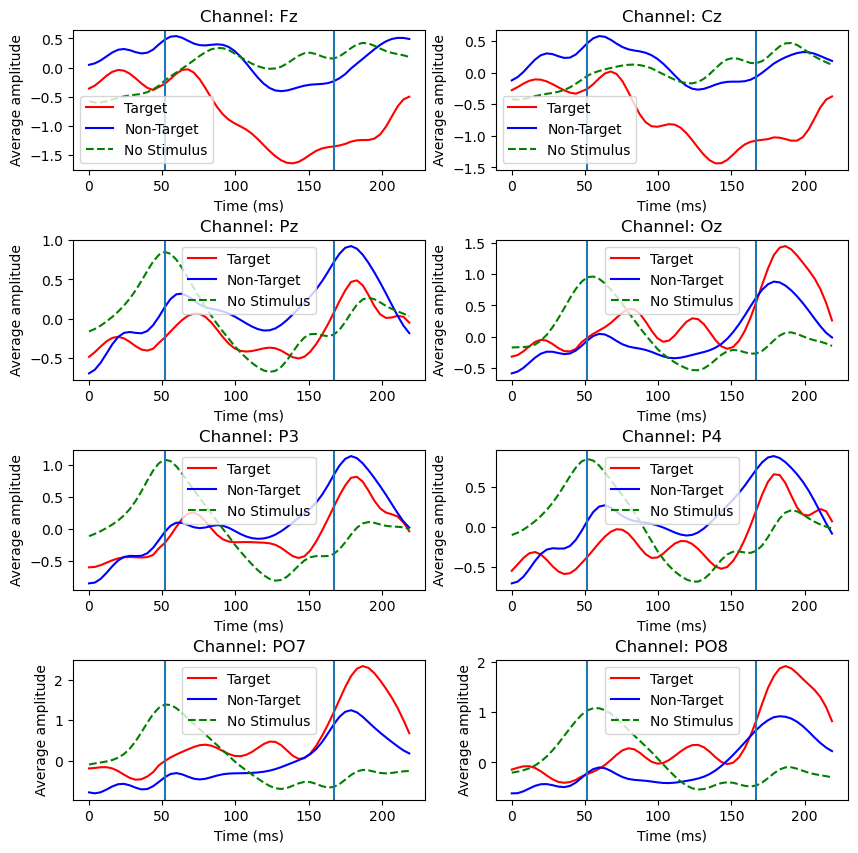

In [306]:
additional_duration_of_waveform = 50 #ms
additional_samples = int(sample_frequency * additional_duration_of_waveform / 1000)


mt_average = [None for _ in range(x.shape[-1])]
nt_average = [None for _ in range(x.shape[-1])]
ns_average = [None for _ in range(x.shape[-1])]

# Visualize channel output
for i in range(x.shape[0]):
    cols = 2
    rows = x.shape[-1]//cols
    if int(rows) != rows:
        rows = int(rows) + 1
    else:
        rows = int(rows)
        
#     fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
#     plt.suptitle(f"Patient: {i+1}")
    waveforms = collect_waveform_for_each_stimulus_category(x[i], y_target[i], get_delayed_samples=additional_samples, show_progress=True)
    for j in range(x.shape[-1]):    
        if mt_average[j] is None:
            mt_average[j] = np.mean(get_padded_signals(waveforms[target_class][j]), axis=0)
        else:
            mt_average[j] = np.mean(get_padded_signals([mt_average[j], np.mean(get_padded_signals(waveforms[target_class][j]), axis=0)]), axis=0)
            
        if nt_average[j] is None:
            nt_average[j] = np.mean(get_padded_signals(waveforms[non_target_class][j]), axis=0)
        else:
            nt_average[j] = np.mean(get_padded_signals([nt_average[j], np.mean(get_padded_signals(waveforms[non_target_class][j]), axis=0)]), axis=0)
            
        if ns_average[j] is None:
            ns_average[j] = np.mean(get_padded_signals(waveforms[0][j]), axis=0)
        else:
            ns_average[j] = np.mean(get_padded_signals([ns_average[j], np.mean(get_padded_signals(waveforms[0][j]), axis=0)]), axis=0)
        
        


fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
current = 0
for j in range(rows):
    for k in range(cols):
        max_val = np.max([mt_average[current].size, nt_average[current].size, ns_average[current].size])
        counts = np.arange(max_val)
        total_duration = 1000*max_val/sample_frequency
        x_axis = np.linspace(0, total_duration, counts.size)

        ax[j, k].set_title(f"Channel: {get_channel_name(patient_data[0], current)[0]}")
        ax[j, k].plot(x_axis, mt_average[current], 'r-', label='Target')
        ax[j, k].plot(x_axis, nt_average[current], 'b-', label='Non-Target')
        ax[j, k].plot(x_axis, ns_average[current], 'g--', label='No Stimulus')
        
        ax[j, k].axvline((x_axis[np.where(x_axis >= additional_duration_of_waveform)[0][0]], ))
        ax[j, k].axvline((x_axis[np.where(x_axis <= total_duration - additional_duration_of_waveform)[0][-1]], ))

        ax[j, k].set_xlabel("Time (ms)")
        ax[j, k].set_ylabel("Average amplitude")
        ax[j, k].legend()

        current += 1
        
plt.subplots_adjust(hspace=0.5)
plt.show()

The above graph is an extended average of the previous waveform. The blue vertical line in the graph shows when a stimulus starts and when it ends. 

### Parietal region

We can see that on average for most of the parietal region, the amplitude starts to increase right before the stimulus ends and continues to peak a little after the stimulus ends. Finally it decreases towards resting potential which is around -70mv. This behavior is a common characteristic of an action potential. 

Therefore, we can assume that the different places of the parietal region fires an action potential when it receives a target stimulus. The action potential starts at around 200 ms and ends at around 290 ms which is a duration of about 90 ms. Therefore, the stimulus takes about 200 ms to reach the parietal region.

### Frontal region

The frontal region does not show any characteristic action potential during a target or non-target stimulus. However, frontal region plays a role in attention. But it does not show any clear sign of action potential. However, it does have a decreasing amplitude somewhere near 140 ms.

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

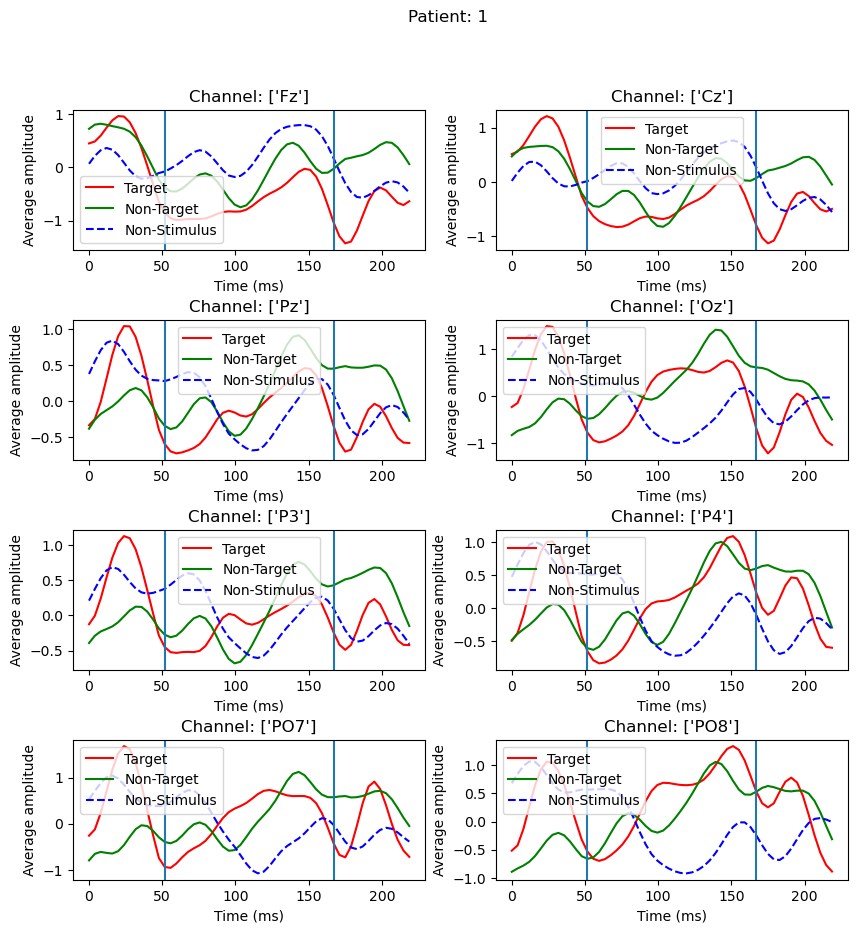

 12%|██████████▌                                                                         | 1/8 [00:01<00:13,  1.86s/it]

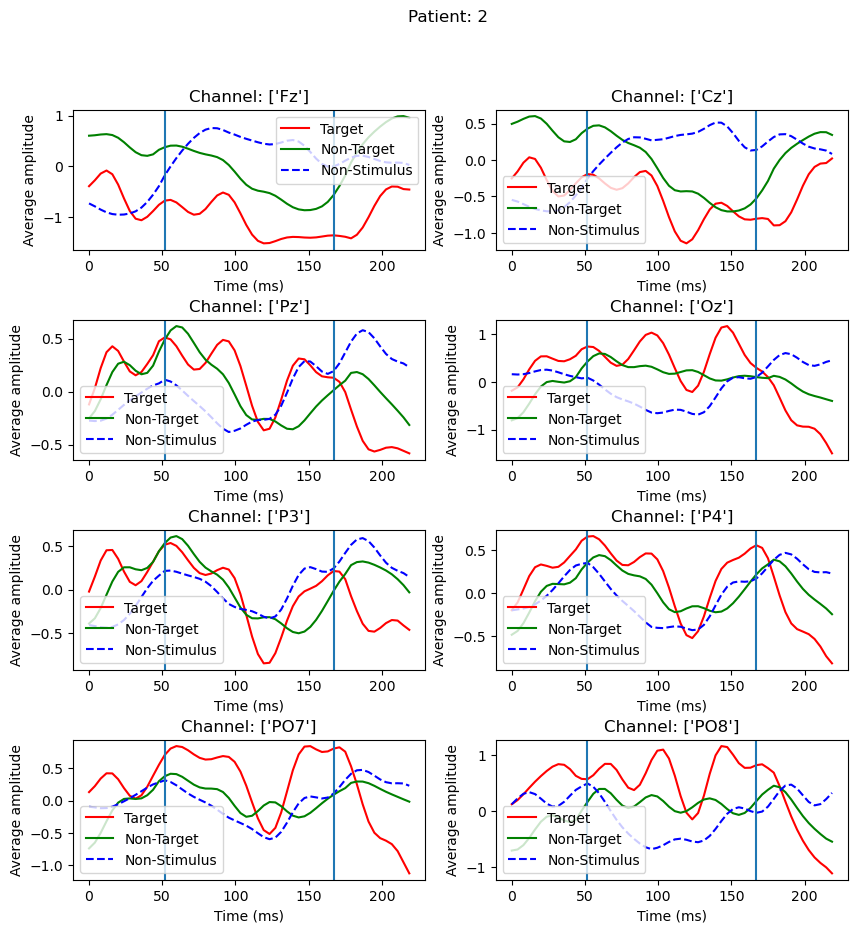

 25%|█████████████████████                                                               | 2/8 [00:04<00:12,  2.15s/it]

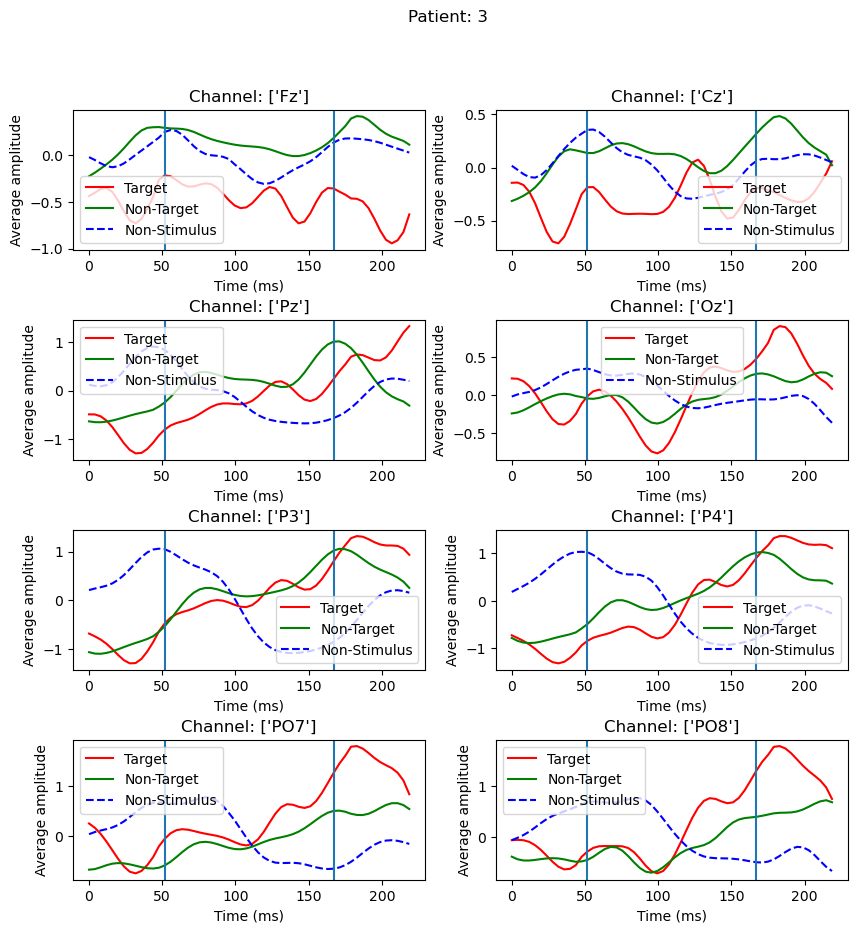

 38%|███████████████████████████████▌                                                    | 3/8 [00:06<00:10,  2.05s/it]

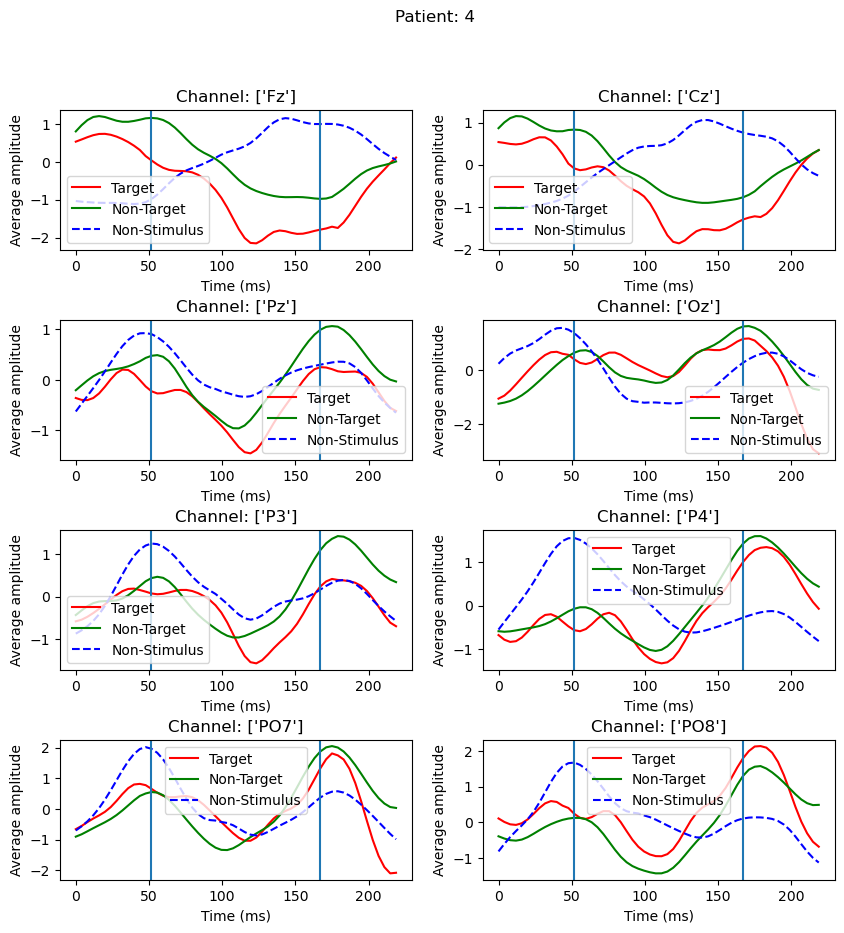

 50%|██████████████████████████████████████████                                          | 4/8 [00:08<00:08,  2.11s/it]

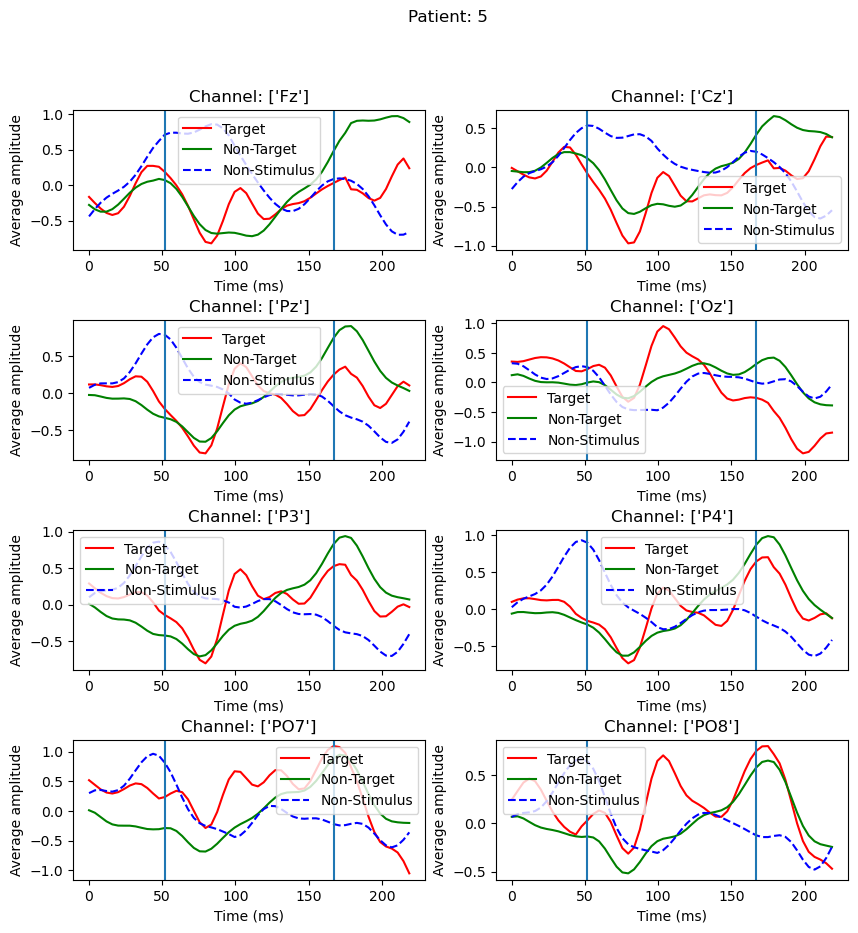

 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:10<00:06,  2.01s/it]

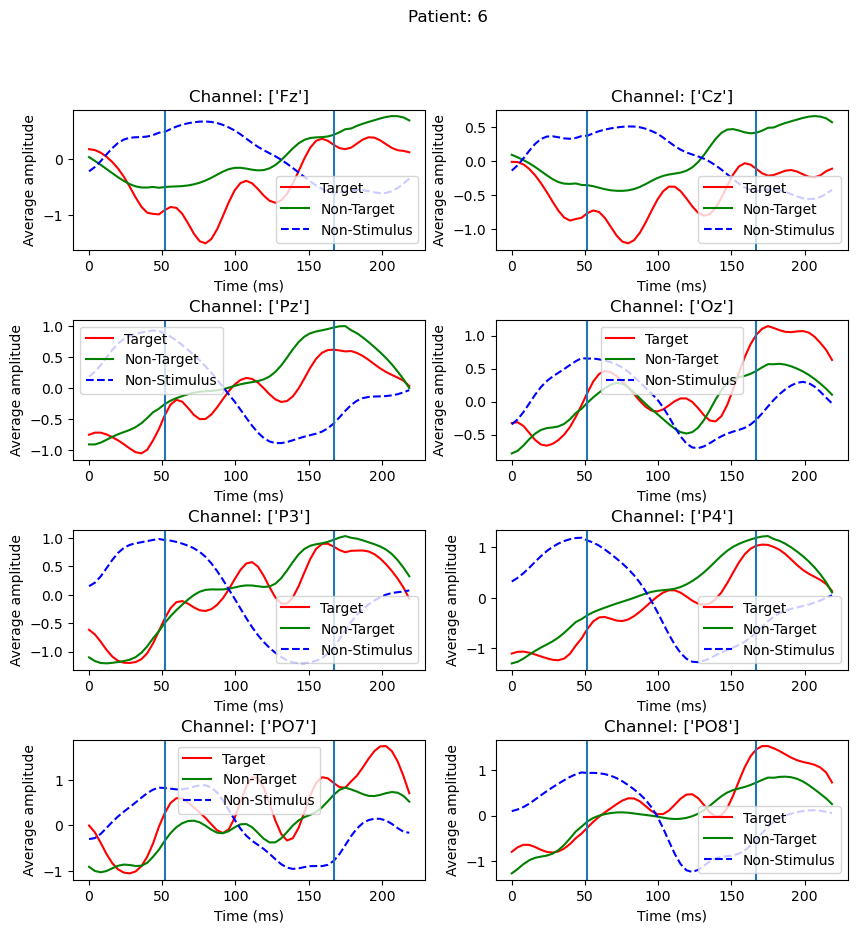

 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:12<00:04,  2.09s/it]

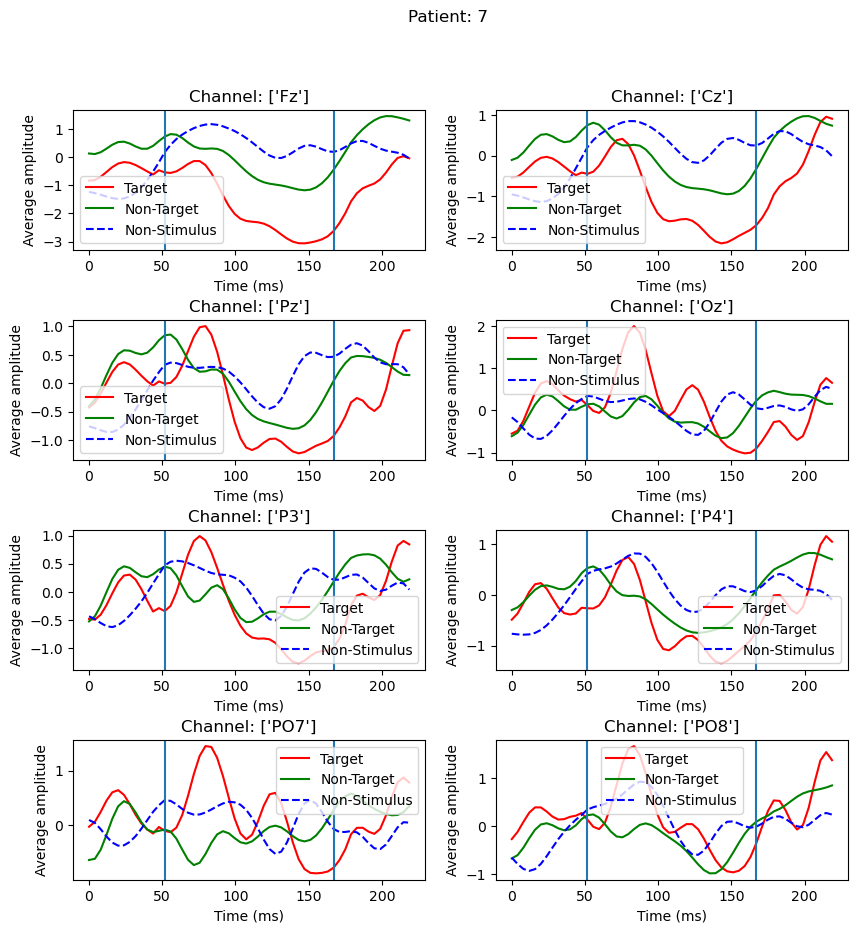

 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:14<00:02,  2.01s/it]

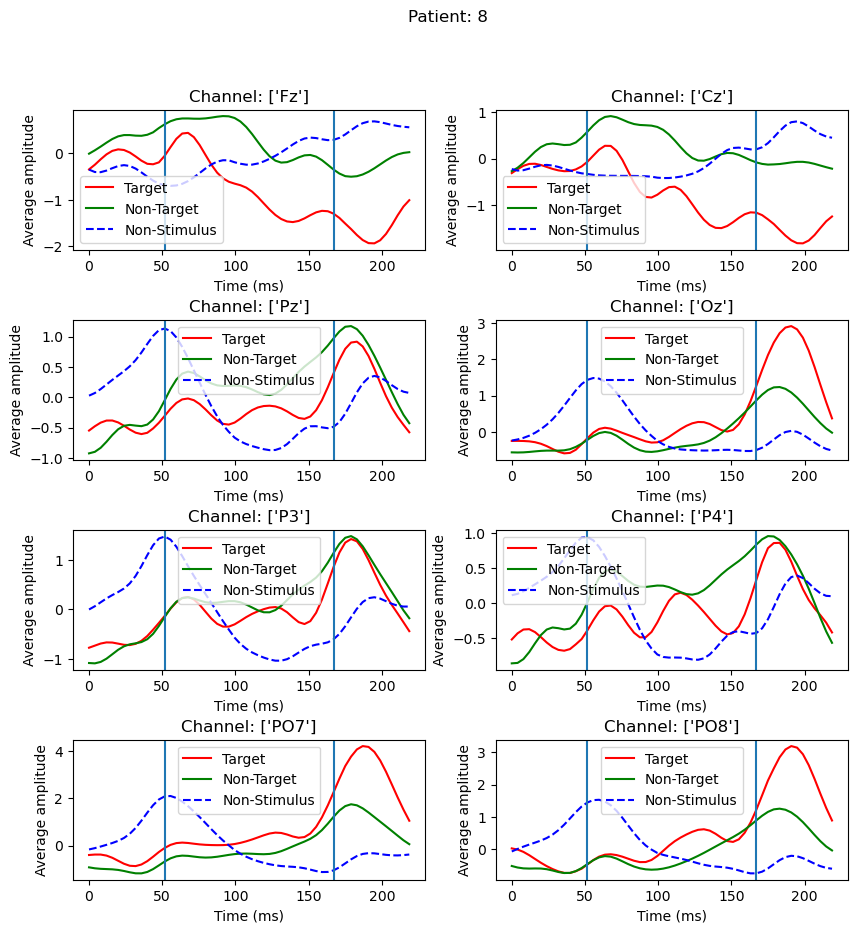

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:16<00:00,  2.06s/it]


In [311]:
additional_duration_of_waveform = 50 #ms
additional_samples = int(sample_frequency * additional_duration_of_waveform / 1000)

        


        
# Visualize channel output
for i in tqdm(range(x.shape[0])):
    cols = 2
    rows = x.shape[-1]//cols
    if int(rows) != rows:
        rows = int(rows) + 1
    else:
        rows = int(rows)
        
        
    fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
    plt.suptitle(f"Patient: {i+1}")
    current = 0
    waveforms = collect_waveform_for_each_stimulus_category(x[i], y_target[i], get_delayed_samples=additional_samples)
    for j in range(rows):
        for k in range(cols):
            ax[j, k].set_title(f"Channel: {get_channel_name(patient_data[i], current)}")
            
            
            mt = np.mean(get_padded_signals(waveforms[target_class][current]), axis=0)
            nt = np.mean(get_padded_signals(waveforms[non_target_class][current]), axis=0)
            ns = np.mean(get_padded_signals(waveforms[0][current]), axis=0)
            
            
            max_val = np.max([mt.size, nt.size, ns.size])
            counts = np.arange(max_val)
            x_axis = np.linspace(0, 1000*max_val/sample_frequency, counts.size)
            
            
            
            ax[j, k].plot(x_axis, mt, 'r-', label='Target')            
            ax[j, k].plot(x_axis, nt, 'g-', label='Non-Target')            
            ax[j, k].plot(x_axis, ns, 'b--', label='Non-Stimulus')
            
            ax[j, k].axvline((x_axis[np.where(x_axis >= additional_duration_of_waveform)[0][0]], ))
            ax[j, k].axvline((x_axis[np.where(x_axis <= total_duration - additional_duration_of_waveform)[0][-1]], ))
            
            
            ax[j, k].set_xlabel("Time (ms)")
            ax[j, k].set_ylabel("Average amplitude")
            
            current += 1
            
            ax[j, k].legend()
    plt.subplots_adjust(hspace=0.5)
    plt.show()

For most patients PO7, PO8, and Oz shows a pattern of action potential when target stimulus is provided. For some patients (patient 4 and 5), we can also observe a similar pattern for non-target stimulus. However, when no stimulus has been provided none of the channels of any patient show such pattern. We can atleast use this type of pattern to detect whether the patient is processing a stimulus or not.

# Frequency Analysis - Channel Specific